In [743]:
from collections     import OrderedDict, defaultdict
from IPython.display import display, HTML
from os.path         import commonprefix

import datetime
import json
import sys

In [2]:
data_files        = [
    { "infile": "cannon_Test_phylo_4.infiles.csv"       , "classes": "classes_all/report_validation_4.csv"          },
    #{ "infile": "cannon_Test_phylo_oneach.infiles.csv"  , "classes": "classes_all/classes.csv.filled.csv.named.csv.oneeach.csv" },
    { "infile": "cannon_Test_phylo_tomatoes.infiles.csv", "classes": "classes_all/report_validation_tomatoes.csv"   },
    
    { "infile": "cnidaria_11.infiles.csv"               , "classes": "classes_all/report_validation_4.csv"          },
    { "infile": "cnidaria_11.infiles.csv"               , "classes": "classes_all/report_validation_tomatoes.csv"   },
    
    { "infile": "cnidaria_15.infiles.csv"               , "classes": "classes_all/report_validation_4.csv"          },
    { "infile": "cnidaria_15.infiles.csv"               , "classes": "classes_all/report_validation_tomatoes.csv"   },
    
    { "infile": "cnidaria_17.infiles.csv"               , "classes": "classes_all/report_validation_4.csv"          },
    { "infile": "cnidaria_17.infiles.csv"               , "classes": "classes_all/report_validation_tomatoes.csv"   },
    
    { "infile": "cnidaria_21_e_0001_0050.infiles.csv"   , "classes": "classes_all/report_validation_4.csv"          },
    { "infile": "cnidaria_21_e_0001_0050.infiles.csv"   , "classes": "classes_all/report_validation_tomatoes.csv"   },
    
    { "infile": "cnidaria_21_e.infiles.csv"             , "classes": "classes_all/report_validation_4.csv"          },
    { "infile": "cnidaria_21_e.infiles.csv"             , "classes": "classes_all/report_validation_tomatoes.csv"   },
    
    { "infile": "cnidaria_21.infiles.csv"               , "classes": "classes_all/report_validation_4.csv"          },
    { "infile": "cnidaria_21.infiles.csv"               , "classes": "classes_all/report_validation_tomatoes.csv"   },
    
    { "infile": "cnidaria_31.infiles.csv"               , "classes": "classes_all/report_validation_4.csv"          },
    { "infile": "cnidaria_31.infiles.csv"               , "classes": "classes_all/report_validation_tomatoes.csv"   },
]

In [3]:
name_translation_tables = [
    "cannon_filelist_4.csv.filled.csv",
    "cannon_filelist_tomatoes.csv.filled.csv",
    "cannon_filelist_oneach.csv.filled.csv",
    "filelist.csv"
]

In [4]:
class matrices(object):
    def __init__(self, infiles, name_translation_table=None, desired_rows=None, classes_file=None, verbose=False):
        self.fn_filename               = infiles
        self.fn_name_translation_table = name_translation_table
        self.fn_desired_rows           = desired_rows
        self.fn_class                  = classes_file
        self.matrices                  = {}
        self.verbose                   = verbose

        
        if self.fn_name_translation_table:
            self.translation_table = translation_table(verbose=self.verbose)
            for fn_name_translation_table in self.fn_name_translation_table:
                self.translation_table.append(fn_name_translation_table)
        else:
            self.translation_table = None
        
        
        if self.fn_desired_rows:
            self.filternames       = filternames(self.fn_desired_rows, verbose=self.verbose)
        else:
            self.filternames       = None
        
        
        if self.fn_class:
            self.classes           = classification(self.fn_class, verbose=self.verbose)
        else:
            self.classes           = None
        
        print "matrices         :: parsing     : %s" % self.fn_filename
        with open(self.fn_filename) as fhd:
            for infile in fhd:
                infile  = infile.strip()
                matrixl = matrix(infile)
                
                matrixl.rename(   self.translation_table )
                matrixl.filter(   self.filternames       )
                matrixl.classify( self.classes           )
                    
                self.matrices[ infile ] = matrixl
                
    def __repr__(self):
        res = []
        res.append("matrices         :: filename         : %s"  % self.fn_filename       )
        res.append("matrices         :: translation table:\n%s" % self.translation_table )
        res.append("matrices         :: filternames      :\n%s" % self.filternames       )
        res.append("matrices         :: classes          :\n%s" % self.classes           )
        res.append("matrices         :: matrices         :")
        
        for n in self.matrices:
            res.append("matrices         :: matrix           : %s\n%s" % (n, self.matrices[n]) )
        
        return "\n".join(res)

In [5]:
class matrix(object):
    def __init__(self, infile, verbose=False):
        self.filename       = infile
        self.matrix         = []
        self.rownames       = []
        self.classification = None
        self.verbose        = verbose
        
        if False:
            print "matrix           :: parsing     : %s" % self.filename
        
        with open(self.filename) as fhd:
            lc   = -1
            
            for line in fhd:
                lc += 1

                line = line.strip()
                
                if lc == 0:
                    self.rownames = line.split("\t")
                    #print "colnames:", self.rownames
                    
                else:
                    if len(line) == 0:
                        continue
                    
                    row = [ float(x) for x in line.split("\t")[1:] ]
                    
                    assert len(row) == len(self.rownames), "# of data cols (%d) != # of cols (%d)" % (len(row), len(self.rownames))
                    
                    self.matrix.append(row)
                    
        assert len(self.matrix) == len(self.rownames), "# of rows (%d) != # of cols (%d)" % (len(self.matrix), len(self.rownames))
        
    def rename(self, translation_table):
        if translation_table:
            for i, name in enumerate(self.rownames):
                lname = translation_table.translate(name)
                
                self.rownames[i] = lname
                
                if self.verbose:
                    print "matrix           :: translated  : %s > %s" % (name, lname)
        
    def filter(self, filternames):
        if filternames:
            filter_names = set(filternames.names)
            curr_names   = set(self.rownames)
            diff         = curr_names - filter_names
            
            if self.verbose:
                print "filtering", diff
            
            self.delete_regs(list(diff))
    
    def classify(self, classes):
        if classes:
            self.filter_class(classes)
            
            self.classification = classes.classify(self)
    
    def filter_class(self, classes):
        if classes:
            filter_names = set(classes.samples)
            curr_names   = set(self.rownames)
            
            if self.verbose:
                print "matrix           :: filtering class"
                print "filter_names", sorted(list(filter_names               ))
                print "curr_names  ", sorted(list(curr_names                 ))
                print "f - c       ", sorted(list(filter_names - curr_names  ))
                print "c - f       ", sorted(list(curr_names   - filter_names))
            
            
            if   curr_names   < filter_names:
                print "matrix           :: filtering class : curr   names -  filter names %s" % (str(curr_names   - filter_names))
                print "matrix           :: filtering class : filter names -  curr   names %s" % (str(filter_names - curr_names  ))
                print "matrix           :: filtering class : curr   names %s" % (str(sorted(list(curr_names  ))))
                print "matrix           :: filtering class : filter names %s" % (str(sorted(list(filter_names))))
                assert False
                
            else:
                
                if len(list(filter_names - curr_names)) > 0:
                    print "matrix           :: filtering class : filter names <  curr"
                    print "matrix           :: filtering class : curr   names -  filter names %s" % (str(curr_names   - filter_names))
                    print "matrix           :: filtering class : filter names -  curr   names %s" % (str(filter_names - curr_names  ))
                    print "matrix           :: filtering class : curr   names %s" % (str(sorted(list(curr_names  ))))
                    print "matrix           :: filtering class : filter names %s" % (str(sorted(list(filter_names))))
                    assert False

                else:
                    if self.verbose:
                        print "matrix           :: filtering class : filter names == curr   c-f   %s" % (str(curr_names   - filter_names))
                        print "matrix           :: filtering class : filter names == curr   f-c   %s" % (str(filter_names - curr_names  ))
                        print "curr names >= filter names", curr_names   - filter_names

                    diff         = curr_names - filter_names

                    if self.verbose:
                        print "class filtering", diff

                    self.delete_regs(list(diff))
    
    def delete_regs(self, names_to_delete):
        if len(names_to_delete) > 0:
            for name_to_delete in names_to_delete:
                index_to_delete = self.rownames.index(name_to_delete)
                
                if self.verbose:
                    print "matrix           :: delete name : %s index %d" % (name_to_delete, index_to_delete)
                
                del self.rownames[index_to_delete]
                del self.matrix[index_to_delete]
                
                for d in self.matrix:
                    del d[index_to_delete]
                    assert len(self.rownames) == len(d)
                    
                assert len(self.rownames) == len(self.matrix)
                assert len(self.rownames) == len(self.matrix)
    
    def as_html(self):
        html = ["<table>"]
        
        html.append("<tr>")
        html.append("<th>{0}</th>".format("spps"))
        for rn, rt in enumerate(self.rownames):
            html.append("<th>{0}.{1}</th>".format(rn,rt))
        html.append("</tr>")

        
        for rn, row in enumerate(self.matrix):
            html.append("<tr>")
            html.append("<th>{0}.{1}</th>".format(rn, self.rownames[rn]))
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return HTML(''.join(html))
    
    def __repr__(self):
        res = []
        
        res.append("matrix           :: filename    : %s" %    ( self.filename ))
        res.append("matrix           :: rownames    : %d" % len( self.rownames ))
                        
        for f in self.rownames:
            res.append("matrix           :: rowname     : %s" % f)
        
        return "\n".join(res)

In [237]:
class translation_table(object):
    def __init__(self, verbose=False):
        self.filenames = []
        self.names     = {}
        self.verbose   = verbose
        
    def append(self, filename):
        print "translation table:: parsing     : %s" % filename
        
        self.filenames.append( filename )
        
        with open(filename) as fhd:
            for line in fhd:
                line = line.strip()
                
                if len(line) == 0:
                    continue
                
                if line[0] == "#":
                    continue
                
                cols = line.split("\t")
                self.names[ cols[0] ] = cols[1]

    def translate(self, name):
        if name in self.names:
            return self.names[name]
        
        else:
            for lname in self.names:
                if lname.endswith(name):
                    return self.names[lname]
            
            return name
    
    def __repr__(self):
        res = []

        res.append("translation table:: filename    : %s" % ( ",".join(self.filenames) ))
        
        for n in self.names:
            res.append("translation table:: names       : %s: %s" % (n, self.names[n]) )

        return "\n".join( res )

In [7]:
class filternames(object):
    def __init__(self, filename, verbose=False):
        self.filename = filename
        self.names    = []
        self.verbose  = verbose

        print "filternames      :: parsing     : %s" % self.filename, "\n"
        
        with open(filename) as fhd:
            for line in fhd:
                line = line.strip()
                
                if len(line) == 0:
                    continue
                
                if line[0] == "#":
                    continue
                
                self.names.append( line )
                
    def __repr__(self):
        return "filternames      :: filename    : %s names: %s\n" % ( self.filename, ",".join(self.names) )

In [8]:
class classification(object):
    def __init__(self, class_file, verbose=False):
        #verbose=True
        self.filename = class_file
        self.samples  = []
        self.levels   = []
        self.matrix   = []
        self.verbose  = verbose
        
        print "classification   :: parsing     : %s" % self.filename
        
        with open(self.filename) as fhd:
            lc = -1
            for line in fhd:
                lc   += 1
                line  = line.strip()
                
                if len(line) == 0:
                    continue
                
                if line[0] == "#":
                    continue
                
                if lc == 0:
                    self.levels = line.split("\t")[2:]
                    #print "levels", self.levels
                    
                else:
                    cols   = [x.strip() for x in line.split("\t")]
                    cols   = [x if x != '' else None for x in cols]
                    sample =     cols[0]
                    use    = int(cols[1])
                    #print "sample", sample,"use",use,"vals",cols[2:]
                    if use:
                        row = cols[2:]
                        self.samples.append( sample )
                        self.matrix.append(  row    )
                        assert len(self.levels ) == len(row), "number or levels  (%d) != cols (%d)" % (len(self.samples), len(self.matrix[0]))

        assert len(self.samples) == len(self.matrix   ), "number or samples (%d) != rows (%d)" % (len(self.samples), len(self.matrix   ))

        if self.verbose:
            print "classification   :: samples     : ", self.samples, "\n"
            print "classification   :: levels      : ", self.levels , "\n"
            print "classification   :: matrix      : ", self.matrix , "\n"
    
    def classify(self, matrix):
        res = OrderedDict()
        
        for x, m in enumerate(matrix.matrix):
            matrix.matrix[x][x] = sys.maxint
        
        if self.verbose:
            display( matrix.as_html() )
        
        if self.verbose:
            print "classification   :: classify"
            print "classification   :: classify    : levels   : %s" % ( ",".join(self.levels            ) )
            print "classification   :: classify    : samples  : %s" % ( ",".join(sorted(self.samples   )) )
            print "classification   :: classify    : row names: %s" % ( ",".join(sorted(matrix.rownames)) )
        
        
        for level_index, level in enumerate(self.levels):
            level_col = [x[level_index] for x in self.matrix]
            
            res[level] = [[], -1]
            
            if self.verbose:
                print "classification   :: classify    : level: %-10s" % ( level )
                print "classification   :: classify    : col  : %s"    % ( ",".join(level_col) )
            
            for spp_index, spp in enumerate(self.samples):
                spp_class      = level_col[spp_index]
                data_spp_index = matrix.rownames.index(spp)
                
                if self.verbose:
                    print "classification   :: classify    : level: %-10s : spp %-30s : x %4d : class %-20s" % ( level, spp, data_spp_index, spp_class )
                
                assert data_spp_index != -1, "spp %s was not found in matrix: %s" % (spp, ",".join(matrix.rownames))
                
                data_spp_row   = matrix.matrix[data_spp_index]
                data_spp_min   = min(data_spp_row)
                data_spp_count = data_spp_row.count(data_spp_min)
                
                if   data_spp_count == 0:                     #zero. shouldnt happen
                    assert False, "no spp equal to minimum %s" % (str(data_spp_min))
                
                if self.verbose:
                    print "classification   :: classify    : level: %-10s : spp %-30s : x %4d : class %-20s : min   %.3f" % ( level, spp, data_spp_index, spp_class, data_spp_min   )
                    print "classification   :: classify    : level: %-10s : spp %-30s : x %4d : class %-20s : count %d"   % ( level, spp, data_spp_index, spp_class, data_spp_count )
                 
                matches        = [ x == data_spp_min for x in data_spp_row ]
                
                if self.verbose:
                    print "classification   :: classify    : level: %-10s : spp %-30s : x %4d : class %-20s : matches %s" % ( level, spp, data_spp_index, spp_class, ",".join([str(x) for x in matches]) )
                
                lres = []
                
                for match_spp_index, match in enumerate(matches):
                    if match:
                        match_spp_name   = matrix.rownames[    match_spp_index  ]
                        match_spp_classi = self.samples.index( match_spp_name   )
                        match_spp_class  = level_col[          match_spp_classi ]

                        if self.verbose:
                            print "classification   :: classify    : level: %-10s : spp %-30s : x %4d : class %-20s : match %s y %4d ci %4d class %s" % ( level, spp, data_spp_index, spp_class, match_spp_name, match_spp_index, match_spp_classi, match_spp_class )
                        
                        lres.append( 1 if match_spp_class == spp_class else 0 )
                
                if self.verbose:
                    print "classification   :: classify    : level: %-10s : spp %-30s : x %4d : class %-20s : sum %d" % ( level, spp, data_spp_index, spp_class, sum(lres) )
                
                avg = (sum(lres) * 1.0) / len(lres)
                
                if self.verbose:
                    print "classification   :: classify    : level: %-10s : spp %-30s : x %4d : class %-20s : avg %.3f" % ( level, spp, data_spp_index, spp_class, avg )
                
                res[level][0].append( 1 if avg >= 0.50 else 0 )
                
                if self.verbose:
                    print "classification   :: classify    : level: %-10s : spp %-30s : x %4d : class %-20s : res %s" % ( level, spp, data_spp_index, spp_class, str(1 if avg >= 0.50 else 0) )
            
            res[level][1] = (sum(res[level][0]) * 1.0) / len(res[level][0])
            if self.verbose:
                print "classification   :: classify    : level: %-10s : sum %4d / %4d res %.4f" % ( level, sum(res[level][0]), len(res[level][0]), res[level][1] )
                
        return res

In [9]:
#matrix_data = matrices(infiles_file, filelist=filelist_file, desired_rows=desired_rows_file, classes=classes)
#matrix_data = matrices(infiles_file, filelist=filelist_file, classes_files=classes_files)

for data_file in data_files:
    print "\n\n", data_file
    data_file["matrices"] = matrices(data_file["infile"], name_translation_table=name_translation_tables, classes_file=data_file["classes"])



{'classes': 'classes_all/report_validation_4.csv', 'infile': 'cannon_Test_phylo_4.infiles.csv'}
translation table:: parsing     : cannon_filelist_4.csv.filled.csv
translation table:: parsing     : cannon_filelist_tomatoes.csv.filled.csv
translation table:: parsing     : cannon_filelist_oneach.csv.filled.csv
translation table:: parsing     : filelist.csv
classification   :: parsing     : classes_all/report_validation_4.csv
matrices         :: parsing     : cannon_Test_phylo_4.infiles.csv


{'classes': 'classes_all/report_validation_tomatoes.csv', 'infile': 'cannon_Test_phylo_tomatoes.infiles.csv'}
translation table:: parsing     : cannon_filelist_4.csv.filled.csv
translation table:: parsing     : cannon_filelist_tomatoes.csv.filled.csv
translation table:: parsing     : cannon_filelist_oneach.csv.filled.csv
translation table:: parsing     : filelist.csv
classification   :: parsing     : classes_all/report_validation_tomatoes.csv
matrices         :: parsing     : cannon_Test_phylo_tomat

In [10]:
def rec_dd():
    return defaultdict(rec_dd)

In [11]:
verbose   = False
avail_cls = set([])

for data_file in data_files:
    cls       = data_file["matrices"].classes.levels
    avail_cls = avail_cls | set(cls)

avail_cls = sorted(list(avail_cls))
    
print avail_cls

['family', 'genus', 'kingdom', 'order', 'phylum', 'species']


In [241]:
cls_order = [
    'kingdom',
    'phylum',
    'order',
    'family',
    'genus',
    'species'
]
avail_cls = cls_order
avail_cls

['kingdom', 'phylum', 'order', 'family', 'genus', 'species']

In [12]:
replace_rules = [
    ('annon_Test_phylo_4'            , 'RepeatFree_21'          ),
    ('annon_Test_phylo_tomatoes'     , 'RepeatFree_21'          ),
    ('nidaria_'                      , 'Cnidaria_'              ),
    ('Cnidaria_21_e'                 , 'Cnidaria_21_extended'   ),
    ('Cnidaria_21_extended_0001_0050', 'Cnidaria_21_extended_2%'),
    ('_'                             , ' '                      )
]

In [242]:
summary   = defaultdict(rec_dd)

dcp       = commonprefix([ x["infile"]       for x in data_files ])
dce       = commonprefix([ x["infile"][::-1] for x in data_files ])[::-1]

for data_file in data_files:
    print "\n\n", data_file["infile"], data_file["classes"]
    
    infile   = data_file["infile"  ]
    matrices = data_file["matrices"].matrices
    
    mcp      = commonprefix(matrices)
    mce      = commonprefix([x[::-1] for x in matrices])[::-1]
    
    dshortL  = infile[len(dcp):len(infile)-len(dce)]

    dshort   = dshortL

    for rule in replace_rules:
        dshort = dshort.replace(rule[0], rule[1])

    #if verbose:
    print dshort
    
    for matrix_data in sorted(matrices):
        if verbose:
            print "  matrix_data", matrix_data
        
        cls    = matrices[matrix_data].classification
        
        mshort = matrix_data[len(mcp):len(matrix_data)-len(mce)]
        
        if verbose:
            print "  mshort", mshort
        
        for classi in cls:
            val = cls[classi]
            
            if verbose:
                print "   class %-10s: %.4f" % (classi, val[1])
                
            summary[ dshort ][ mshort ][ classi ] = val[1]
            
            if verbose:
                print dshort, mshort, classi, val[1]



cannon_Test_phylo_4.infiles.csv classes_all/report_validation_4.csv
RepeatFree 21


cannon_Test_phylo_tomatoes.infiles.csv classes_all/report_validation_tomatoes.csv
RepeatFree 21


cnidaria_11.infiles.csv classes_all/report_validation_4.csv
Cnidaria 11


cnidaria_11.infiles.csv classes_all/report_validation_tomatoes.csv
Cnidaria 11


cnidaria_15.infiles.csv classes_all/report_validation_4.csv
Cnidaria 15


cnidaria_15.infiles.csv classes_all/report_validation_tomatoes.csv
Cnidaria 15


cnidaria_17.infiles.csv classes_all/report_validation_4.csv
Cnidaria 17


cnidaria_17.infiles.csv classes_all/report_validation_tomatoes.csv
Cnidaria 17


cnidaria_21_e_0001_0050.infiles.csv classes_all/report_validation_4.csv
Cnidaria 21 extended 2%


cnidaria_21_e_0001_0050.infiles.csv classes_all/report_validation_tomatoes.csv
Cnidaria 21 extended 2%


cnidaria_21_e.infiles.csv classes_all/report_validation_4.csv
Cnidaria 21 extended


cnidaria_21_e.infiles.csv classes_all/report_validation_tomatoe

In [243]:
csv_data  = []
csv_data.append( [ 'test_name', 'statistics' ] + avail_cls )

for infile in sorted(summary):
    for matrix_name in sorted(summary[infile]):
        row = [ infile, matrix_name ] + [None]*len(avail_cls)
        
        for classi in summary[infile][matrix_name]:
            row[ avail_cls.index(classi) + 2 ] = summary[infile][matrix_name][classi]
        csv_data.append( row )

In [15]:
if False:
    print json.dumps( summary, sort_keys=True, indent=1 )

In [16]:
if False:
    print json.dumps( csv_data, sort_keys=True, indent=1 )

In [244]:
with open('report.csv', 'w') as fhd:
    for line in csv_data:
        fhd.write("\t".join([str(x) for x in line]))
        fhd.write("\n")

In [740]:
%matplotlib inline

import matplotlib
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

from   matplotlib.backends.backend_pdf import PdfPages
from   pandas.tools.plotting           import parallel_coordinates
from   matplotlib        import cm
from   pylab             import rcParams
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [487]:
mr = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', len(csv_data)+1)

if not avail_cls:
    avail_cls = "family,genus,kingdom,order,phylum,species".split(",")

datatypes = [('test_name', np.str_),('statistics', np.str_)] + [(x, np.float64) for x in avail_cls]
pd_data = pd.read_csv('report.csv', sep="\t", dtype=datatypes, na_values="None")

pd_data[ avail_cls ] = pd_data[ avail_cls ] * 100.0

display( pd_data )

pd.set_option('display.max_rows', mr)

test_name                statistics     kingdom  \
0                Cnidaria 11             D_bray_curtis   76.666667   
1                Cnidaria 11                   D_chord   76.666667   
2                Cnidaria 11                  D_euclid   76.666667   
3                Cnidaria 11                 D_hamming   76.666667   
4                Cnidaria 11               D_hellinger   76.666667   
5                Cnidaria 11                 D_jaccard   76.666667   
6                Cnidaria 11            D_jaccard_sqrt   76.666667   
7                Cnidaria 11          D_lance_williams   76.666667   
8                Cnidaria 11          D_mean_manhattan   76.666667   
9                Cnidaria 11      D_pattern_difference   66.666667   
10               Cnidaria 11       D_shaped_difference   73.333333   
11               Cnidaria 11        D_sized_difference   76.666667   
12               Cnidaria 11          D_squared_euclid   76.666667   
13               Cnidaria 11                    D_vari   76.666667   
14               Cnidaria 11                   D_yuleq   73.333333   
15               Cnidaria 11               S_anderberg   76.666667   
16               Cnidaria 11   S_baroni_urbani_buser_I   76.666667   
17               Cnidaria 11  S_baroni_urbani_buser_II   76.666667   
18               Cnidaria 11           S_braun_banquet   93.333333   
19               Cnidaria 11                    S_cole   66.666667   
20               Cnidaria 11                  S_cosine   80.000000   
21               Cnidaria 11                  S_dennis   66.666667   
22               Cnidaria 11                    S_dice   76.666667   
23               Cnidaria 11              S_dispersion   76.666667   
24               Cnidaria 11          S_driver_kroeber   76.666667   
25               Cnidaria 11                  S_eyraud   73.333333   
26               Cnidaria 11           S_fager_mcgowan   73.333333   
27               Cnidaria 11                   S_faith   76.666667   
28               Cnidaria 11                S_forbes_I   66.666667   
29               Cnidaria 11               S_forbes_II   66.666667   
30               Cnidaria 11                  S_fossum   66.666667   
31               Cnidaria 11           S_gilbert_wells   66.666667   
32               Cnidaria 11         S_goodman_kruskal   76.666667   
33               Cnidaria 11                   S_gower   73.333333   
34               Cnidaria 11          S_gower_legendre   76.666667   
35               Cnidaria 11                  S_hamann   76.666667   
36               Cnidaria 11            S_innerproduct   26.666667   
37               Cnidaria 11            S_intersection   26.666667   
38               Cnidaria 11                 S_jaccard   23.333333   
39               Cnidaria 11               S_jaccard3w   76.666667   
40               Cnidaria 11                  S_johson   76.666667   
41               Cnidaria 11            S_kulczynski_I   73.333333   
42               Cnidaria 11           S_kulczynski_II   76.666667   
43               Cnidaria 11            S_mcconnaughey   76.666667   
44               Cnidaria 11                 S_michael   70.000000   
45               Cnidaria 11               S_mountford   76.666667   
46               Cnidaria 11                  S_nei_li   76.666667   
47               Cnidaria 11                S_ochiai_I   76.666667   
48               Cnidaria 11               S_ochiai_II   76.666667   
49               Cnidaria 11                  S_otsuka   76.666667   
50               Cnidaria 11               S_pearson_I   70.000000   
51               Cnidaria 11              S_pearson_II   76.666667   
52               Cnidaria 11             S_pearson_III   76.666667   
53               Cnidaria 11         S_pearson_heron_I   76.666667   
54               Cnidaria 11        S_pearson_heron_II   66.666667   
55               Cnidaria 11                  S_pierce   46.666667   
56               Cnidaria 11 

In [488]:
pd_data.dtypes

test_name      object
statistics     object
kingdom       float64
phylum        float64
order         float64
family        float64
genus         float64
species       float64
dtype: object

In [489]:
dbs = pd.Series.unique(pd_data["test_name"])
dbs

array(['Cnidaria 11', 'Cnidaria 15', 'Cnidaria 17', 'Cnidaria 21',
       'Cnidaria 21 extended', 'Cnidaria 21 extended 2%', 'Cnidaria 31',
       'RepeatFree 21'], dtype=object)

In [490]:
stats = pd.Series.unique(pd_data["statistics"])
print len(stats)
stats

71


array(['D_bray_curtis', 'D_chord', 'D_euclid', 'D_hamming', 'D_hellinger',
       'D_jaccard', 'D_jaccard_sqrt', 'D_lance_williams',
       'D_mean_manhattan', 'D_pattern_difference', 'D_shaped_difference',
       'D_sized_difference', 'D_squared_euclid', 'D_vari', 'D_yuleq',
       'S_anderberg', 'S_baroni_urbani_buser_I',
       'S_baroni_urbani_buser_II', 'S_braun_banquet', 'S_cole', 'S_cosine',
       'S_dennis', 'S_dice', 'S_dispersion', 'S_driver_kroeber',
       'S_eyraud', 'S_fager_mcgowan', 'S_faith', 'S_forbes_I',
       'S_forbes_II', 'S_fossum', 'S_gilbert_wells', 'S_goodman_kruskal',
       'S_gower', 'S_gower_legendre', 'S_hamann', 'S_innerproduct',
       'S_intersection', 'S_jaccard', 'S_jaccard3w', 'S_johson',
       'S_kulczynski_I', 'S_kulczynski_II', 'S_mcconnaughey', 'S_michael',
       'S_mountford', 'S_nei_li', 'S_ochiai_I', 'S_ochiai_II', 'S_otsuka',
       'S_pearson_I', 'S_pearson_II', 'S_pearson_III', 'S_pearson_heron_I',
       'S_pearson_heron_II', 'S_pierc

In [491]:
mr = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', len(dbs)*8 + 2)

display(pd_data.groupby('test_name').describe())

pd.set_option('display.max_rows', mr)

family       genus     kingdom       order  \
test_name                                                                       
Cnidaria 11             count   71.000000   71.000000   71.000000   71.000000   
                        mean    57.464789   44.366197   71.924883   57.464789   
                        std     13.644753   20.668138   11.306157   13.644753   
                        min      3.333333    0.000000   23.333333    3.333333   
                        25%     53.333333   41.666667   70.000000   53.333333   
                        50%     63.333333   56.666667   76.666667   63.333333   
                        75%     63.333333   56.666667   76.666667   63.333333   
                        max     80.000000   73.333333   93.333333   80.000000   
Cnidaria 15             count   71.000000   71.000000   71.000000   71.000000   
                        mean    63.990610   57.183099   72.300469   63.990610   
                        std     21.139144   22.946784   16.757766   21.139144   
                        min      0.000000    0.000000    3.333333    0.000000   
                        25%     60.000000   53.333333   73.333333   60.000000   
                        50%     63.333333   60.000000   73.333333   63.333333   
                        75%     80.000000   73.333333   80.000000   80.000000   
                        max     93.333333   86.666667   93.333333   93.333333   
Cnidaria 17             count   71.000000   71.000000   71.000000   71.000000   
                        mean    68.826291   63.990610   77.746479   68.826291   
                        std     27.637670   30.360897   22.094851   27.637670   
                        min      0.000000    0.000000    3.333333    0.000000   
                        25%     60.000000   58.333333   73.333333   60.000000   
                        50%     60.000000   60.000000   80.000000   60.000000   
                        75%     96.666667   93.333333   96.666667   96.666667   
                        max    100.000000  100.000000  100.000000  100.000000   
Cnidaria 21             count   71.000000   71.000000   71.000000   71.000000   
                        mean    79.436620   76.150235   84.037559   79.436620   
                        std     31.852766   36.334635   26.773094   31.852766   
                        min      0.000000    0.000000    0.000000    0.000000   
                        25%     66.666667   65.000000   76.666667   66.666667   
                        50%     96.666667   96.666667   96.666667   96.666667   
                        75%    100.000000  100.000000  100.000000  100.000000   
                        max    100.000000  100.000000  100.000000  100.000000   
Cnidaria 21 extended    count   71.000000   71.000000   71.000000   71.000000   
                        mean    79.436620   76.150235   84.037559   79.436620   
                        std     31.852766   36.334635   26.773094   31.852766   
                        min      0.000000    0.000000    0.000000    0.000000   
                        25%     66.666667   65.000000   76.666667   66.666667   
                        50%     96.666667   96.666667   96.666667   96.666667   
                        75%    100.000000  100.000000  100.000000  100.000000   
                        max    100.000000  100.000000  100.000000  100.000000   
Cnidaria 21 extended 2% count   71.000000   71.000000   71.000000   71.000000   
                        mean    79.812207   76.525822   84.319249   79.812207   
                        std     31.777437   35.739075   26.764074   31.777437   
                        min      0.000000    0.000000    0.000000    0.000000   
                        25%     68.333333   65.000000   78.333333   68.333333   
                        50%     96.666667   96.666667   96.666667   96.666667   
                        75%    100.000000  100.000000  100.000000  100.000000   
                        max    100.000000  100.000000  100.000000 

In [492]:
mr = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', len(stats)*8 + 2)

display(pd_data.groupby('statistics').describe())

pd.set_option('display.max_rows', mr)

family       genus     kingdom  \
statistics                                                           
D_bray_curtis            count    8.000000    8.000000    8.000000   
                         mean    91.250000   89.166667   92.916667   
                         std     13.325891   16.010909    9.667077   
                         min     63.333333   56.666667   76.666667   
                         25%     87.500000   85.833333   87.500000   
                         50%     98.333333   96.666667   98.333333   
                         75%    100.000000  100.000000  100.000000   
                         max    100.000000  100.000000  100.000000   
D_chord                  count    8.000000    8.000000    8.000000   
                         mean    88.333333   86.666667   90.416667   
                         std     14.029447   16.426846   10.755213   
                         min     63.333333   56.666667   76.666667   
                         25%     79.166667   75.833333   81.666667   
                         50%     93.333333   93.333333   93.333333   
                         75%    100.000000  100.000000  100.000000   
                         max    100.000000  100.000000  100.000000   
D_euclid                 count    8.000000    8.000000    8.000000   
                         mean    64.166667   62.916667   79.583333   
                         std      9.215239    9.667077    6.283640   
                         min     60.000000   56.666667   73.333333   
                         25%     60.000000   60.000000   76.666667   
                         50%     60.000000   60.000000   76.666667   
                         75%     63.333333   60.000000   80.833333   
                         max     86.666667   86.666667   93.333333   
D_hamming                count    8.000000    8.000000    8.000000   
                         mean    64.166667   62.916667   79.583333   
                         std      9.215239    9.667077    6.283640   
                         min     60.000000   56.666667   73.333333   
                         25%     60.000000   60.000000   76.666667   
                         50%     60.000000   60.000000   76.666667   
                         75%     63.333333   60.000000   80.833333   
                         max     86.666667   86.666667   93.333333   
D_hellinger              count    8.000000    8.000000    8.000000   
                         mean    88.333333   86.666667   90.416667   
                         std     14.029447   16.426846   10.755213   
                         min     63.333333   56.666667   76.666667   
                         25%     79.166667   75.833333   81.666667   
                         50%     93.333333   93.333333   93.333333   
                         75%    100.000000  100.000000  100.000000   
                         max    100.000000  100.000000  100.000000   
D_jaccard                count    8.000000    8.000000    8.000000   
                         mean    91.250000   89.166667   92.916667   
                         std     13.325891   16.010909    9.667077   
                         min     63.333333   56.666667   76.666667   
                         25%     87.500000   85.833333   87.500000   
                         50%     98.333333   96.666667   98.333333   
                         75%    100.000000  100.000000  100.000000   
                         max    100.000000  100.000000  100.000000   
D_jaccard_sqrt           count    8.000000    8.000000    8.000000   
                         mean    91.250000   89.166667   92.916667   
                         std     13.325891   16.010909    9.667077   
                         min     63.333333   56.666667   76.666667   
                         25%     87.500000   85.833333   87.500000   
                         50%     98.333333   96.666667   98.333333   
                         75%    100.000000  100.000000  100.000000   
                         max    100.000000  10

In [493]:
"""
return_type='dict', 
'D_bray_curtis', {'boxes': [], 
                  'fliers': [], 
                  'medians': [], 
                  'means': [], 
                  'whiskers': [], 
                  'caps': []
                 }
"""


"""
return_type='both',
OrderedDict(
    [
        (
        'D_bray_curtis', 
            Boxplot(
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c61d2e550>, 
                lines={
                    'boxes': [<matplotlib.lines.Line2D object at 0x7f7c5a3a9410>], 
                    'fliers': [<matplotlib.lines.Line2D object at 0x7f7c5a348690>], 
                    'medians': [<matplotlib.lines.Line2D object at 0x7f7c5a348050>], 
                    'means': [], 
                    'whiskers': [<matplotlib.lines.Line2D object at 0x7f7c5a3a9650>], 
                    'caps': [<matplotlib.lines.Line2D object at 0x7f7c5a3bb390>, ]
                }
            )
        ),
    ]
)
"""


"""
return_type='axes', 
OrderedDict(
    [
        (
            'D_bray_curtis', <matplotlib.axes._subplots.AxesSubplot object at 0x7f7c5a432250>
        )
    ]
)
"""

print

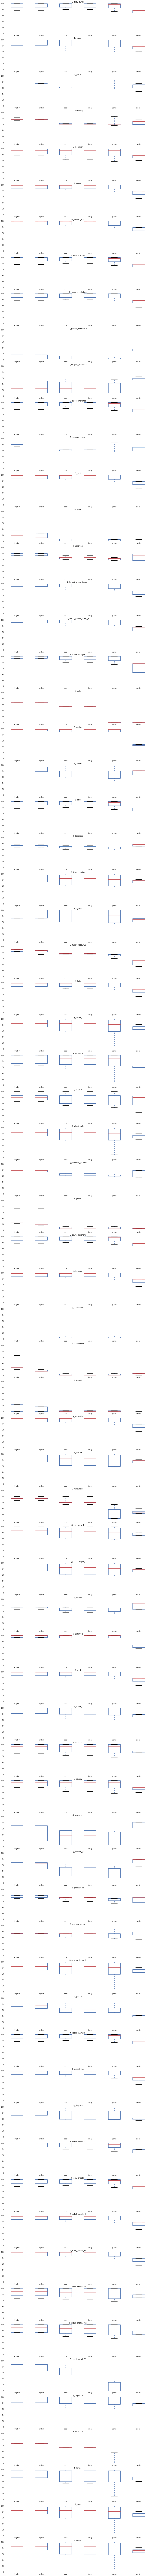

In [502]:
grouped1 = pd_data.groupby(['statistics'])

ca = pd.options.mode.chained_assignment
pd.options.mode.chained_assignment = None

v = grouped1.boxplot(figsize=(16, 300), return_type='both', layout=(len(stats),1))

for k,v in v.items():
    v.ax.set_ylim([0.0,101.0])

plt.show()

pd.options.mode.chained_assignment = ca

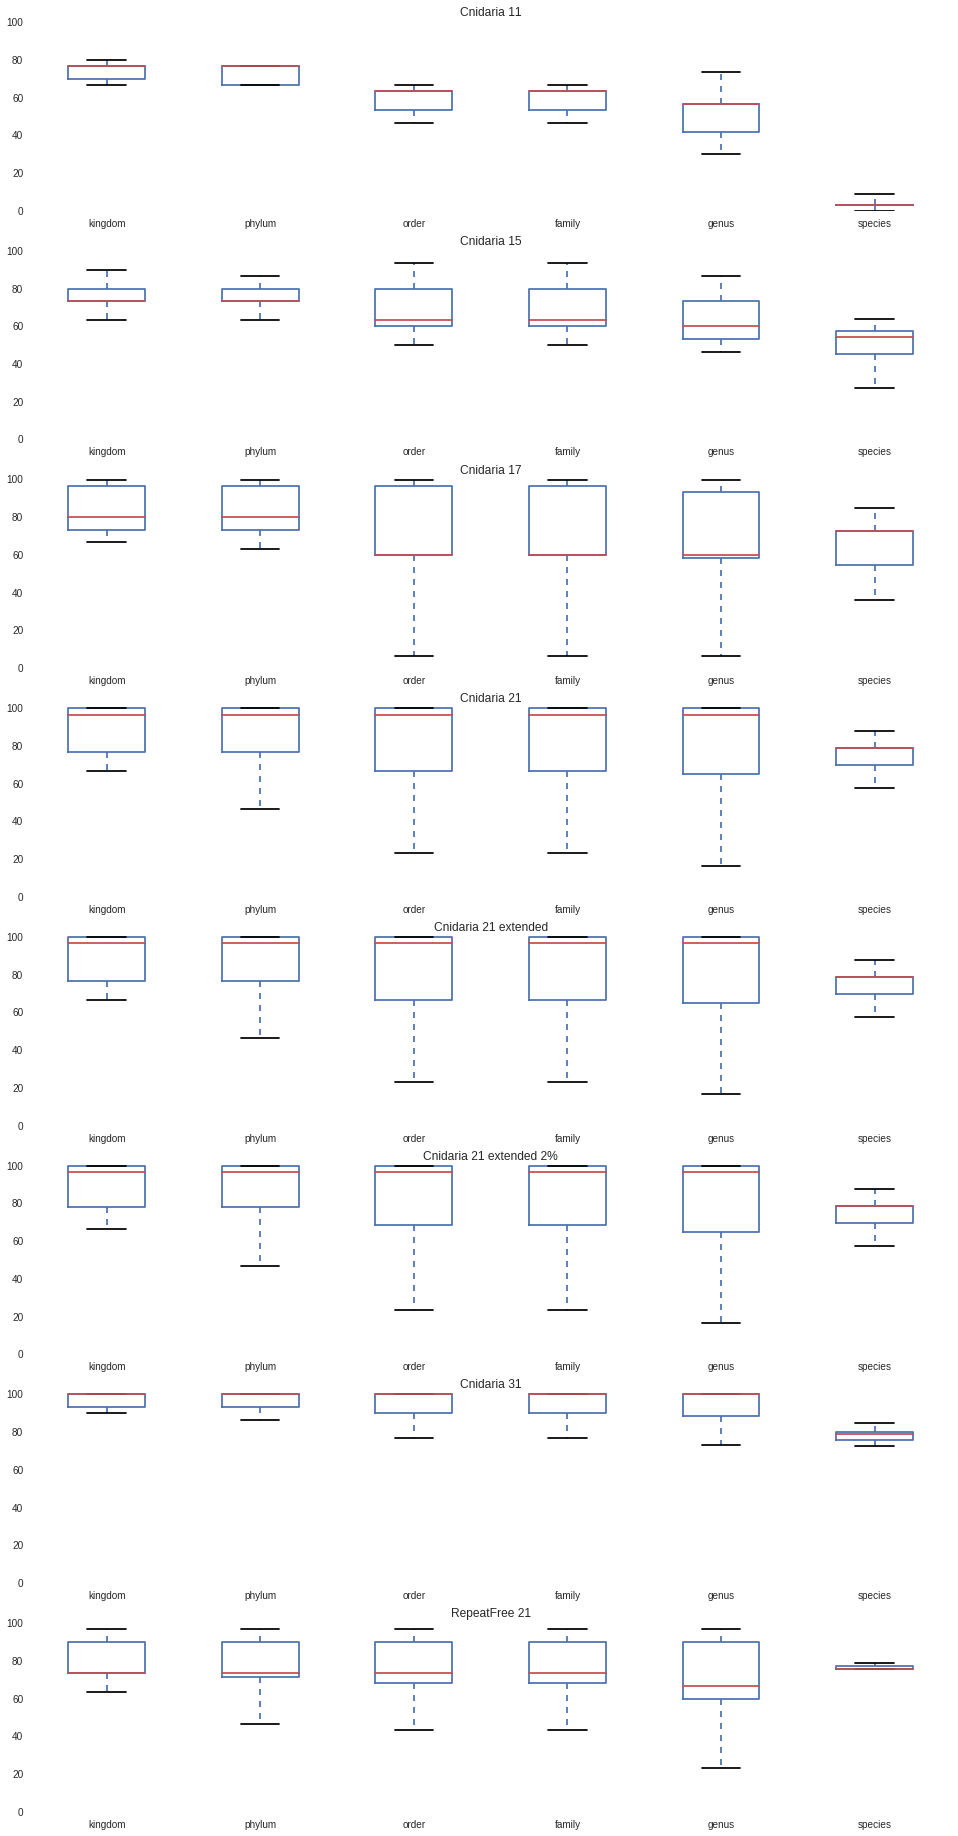

In [503]:
grouped2 = pd_data.groupby(['test_name'])

ca = pd.options.mode.chained_assignment
pd.options.mode.chained_assignment = None

v = grouped2.boxplot(figsize=(16, 300), return_type='both', layout=(len(stats),1))

for k,v in v.items():
    v.ax.set_ylim([0.0,101.0])

plt.show()

pd.options.mode.chained_assignment = ca

In [505]:
if False:
    grouped3 = pd_data.groupby(['test_name', 'statistics'])

    ca = pd.options.mode.chained_assignment
    pd.options.mode.chained_assignment = None

    v = grouped3.boxplot(figsize=(16, 300), return_type='both', layout=(len(stats),1))

    for k,v in v.items():
        v.ax.set_ylim([0.0,101.0])

    plt.show()

    pd.options.mode.chained_assignment = ca

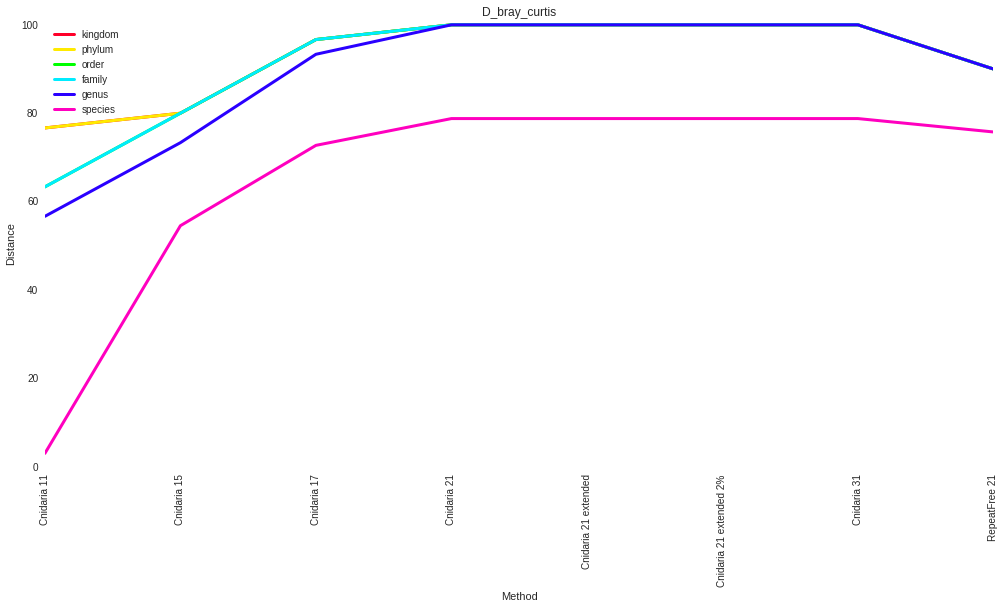

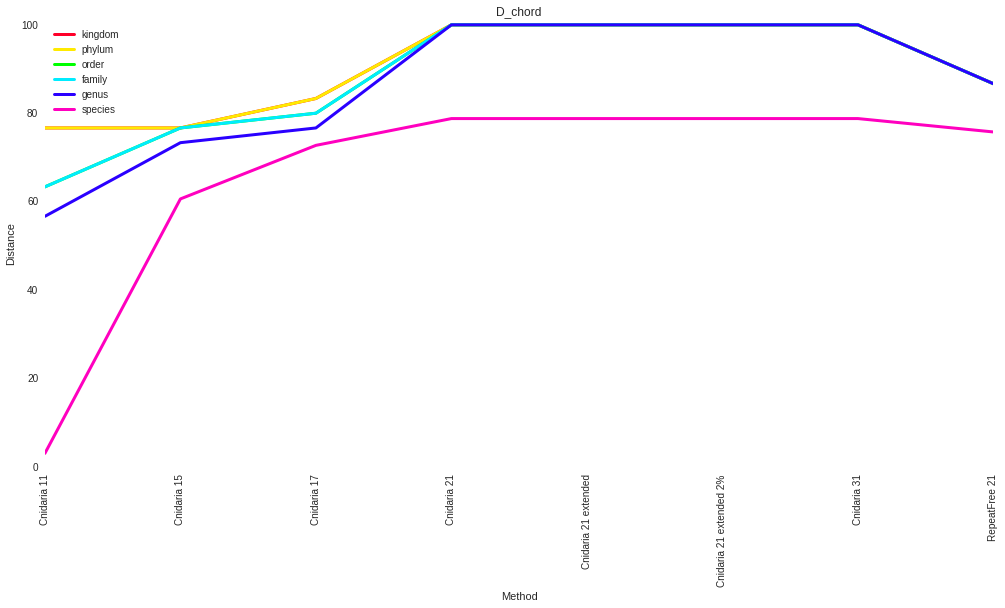

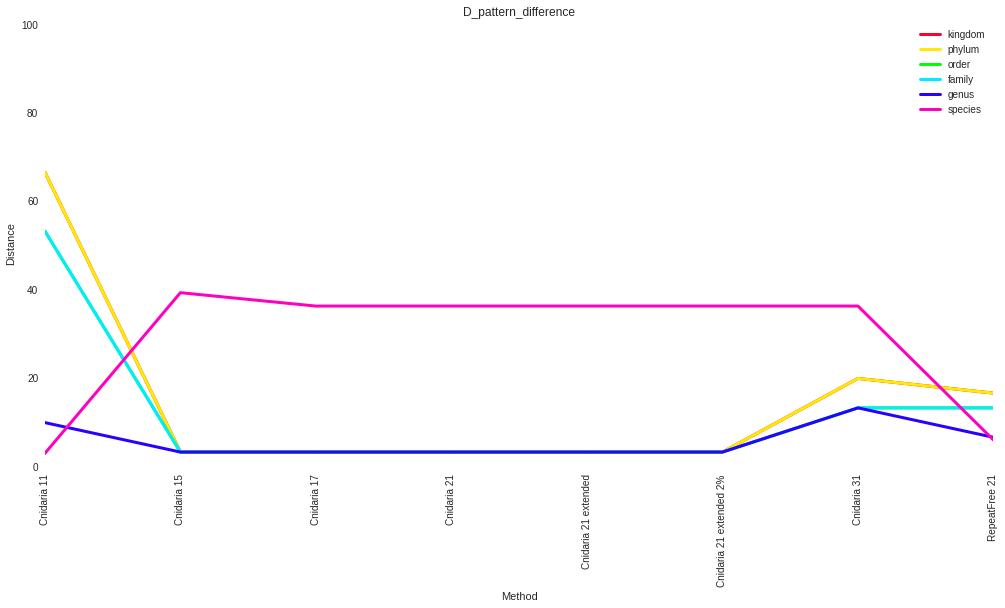

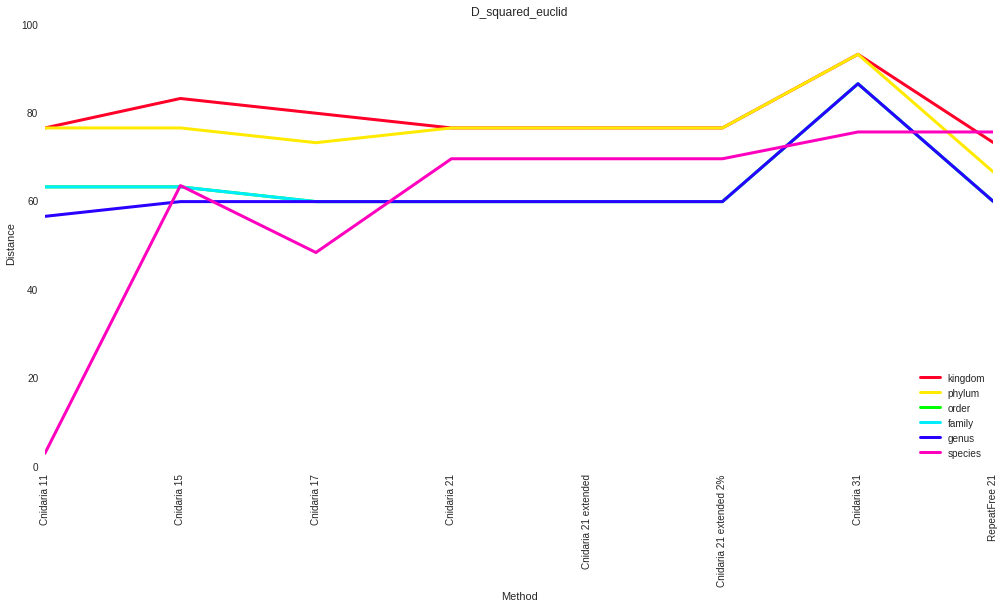

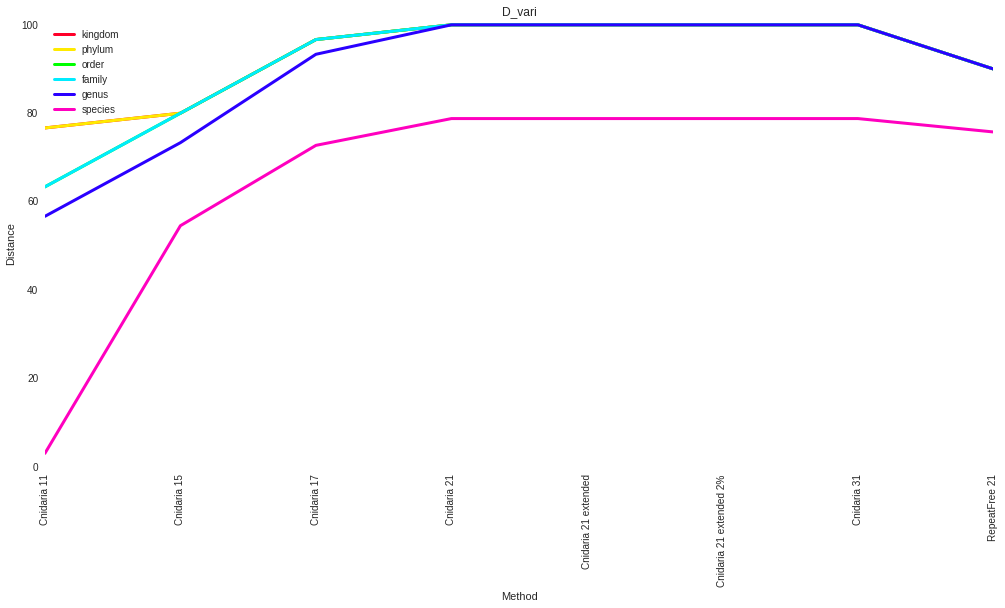

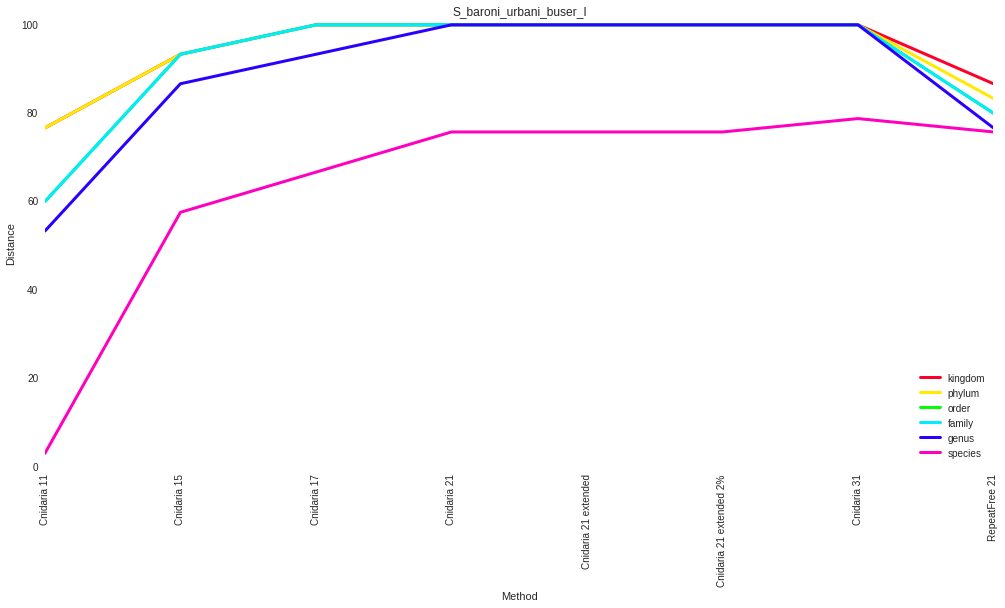

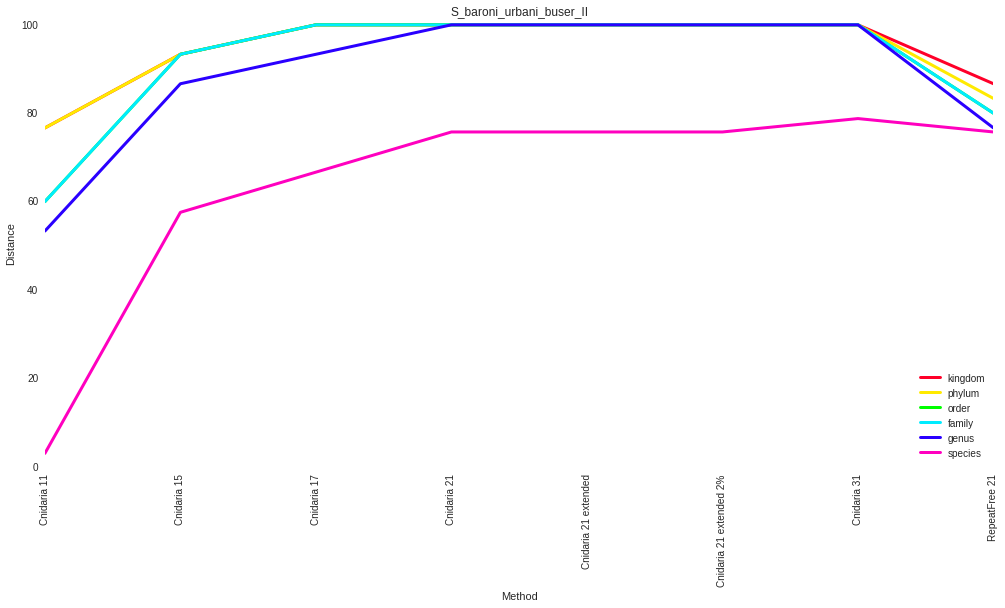

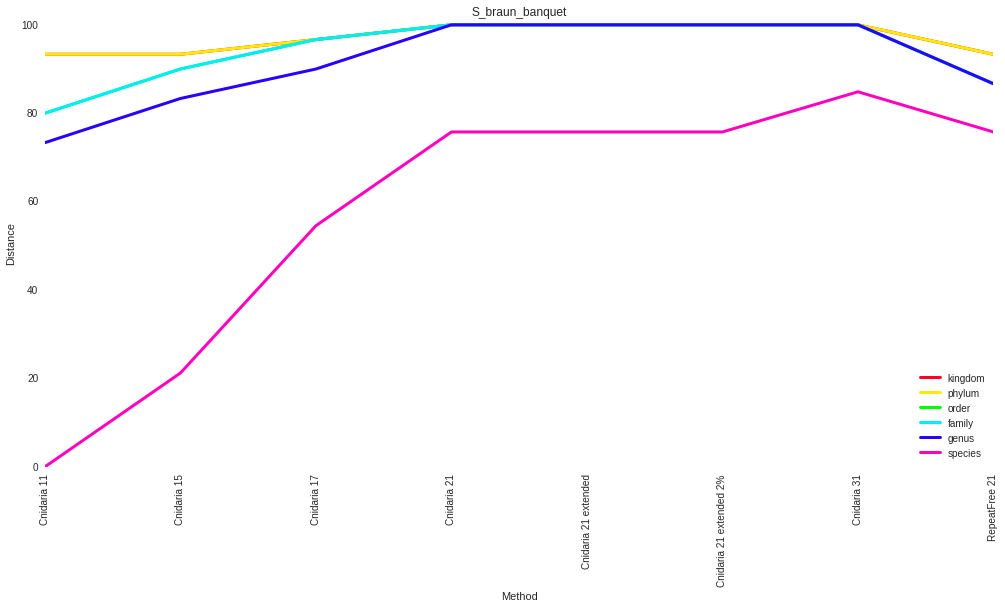

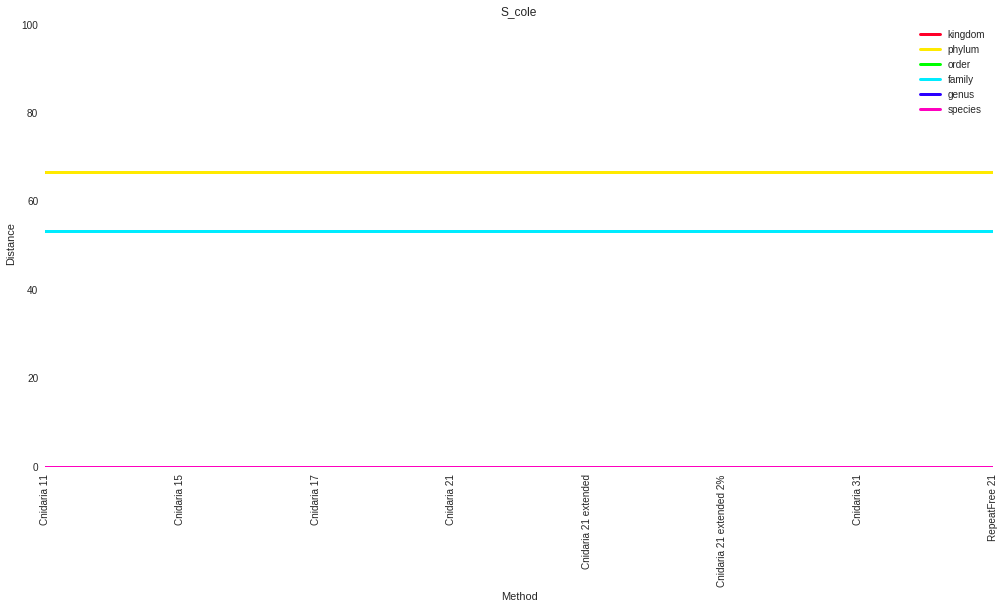

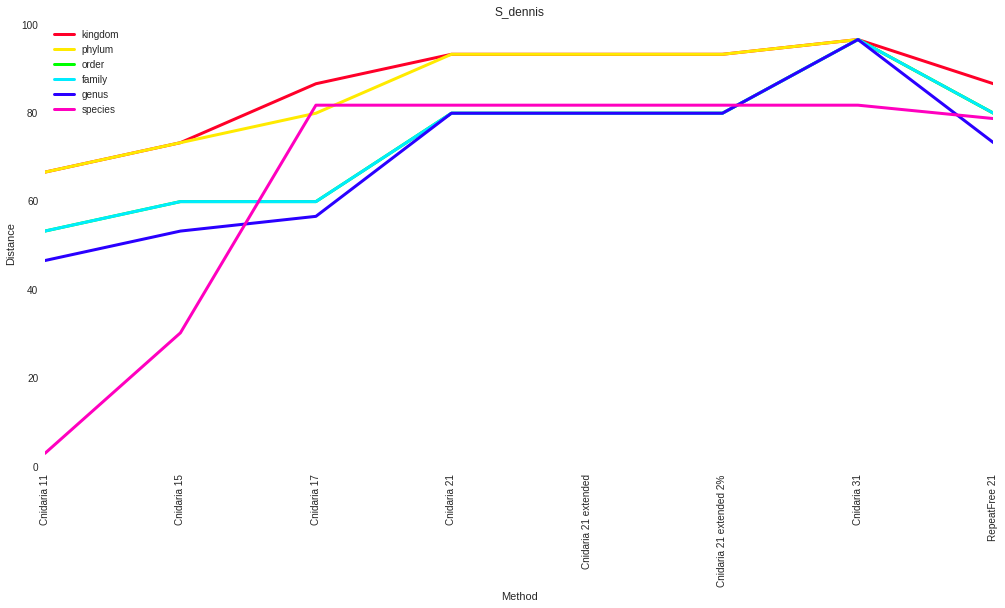

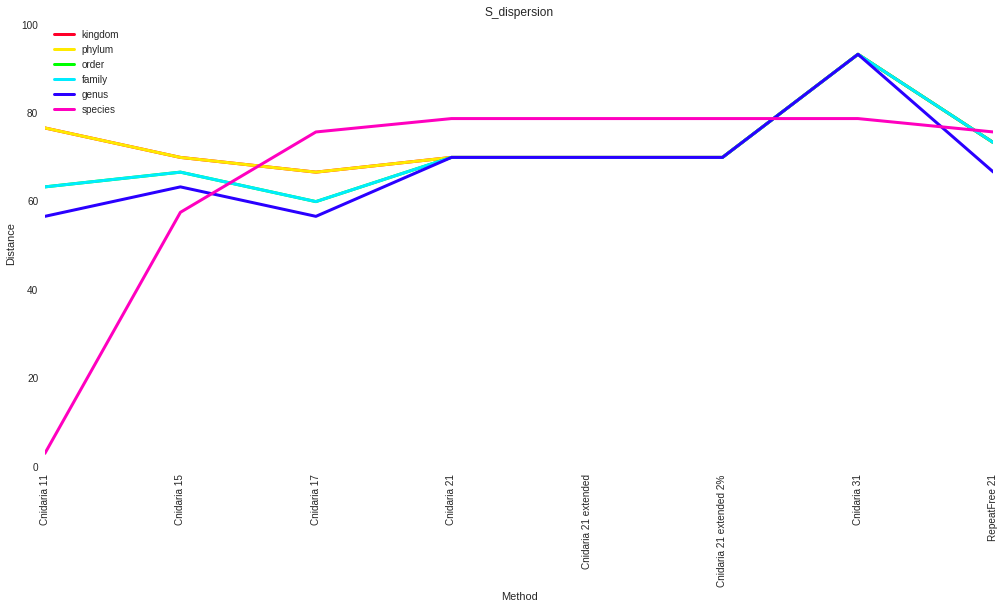

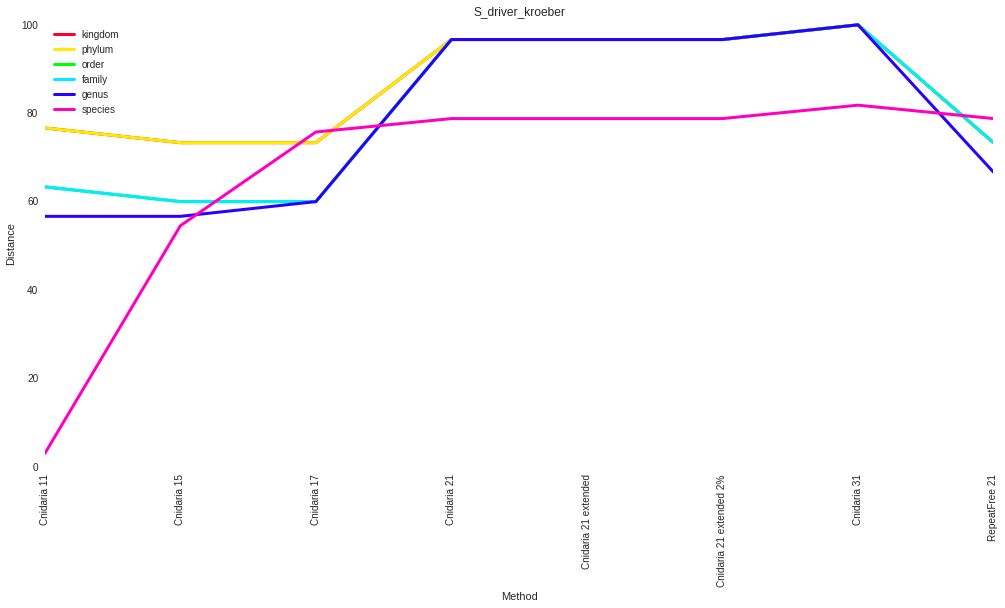

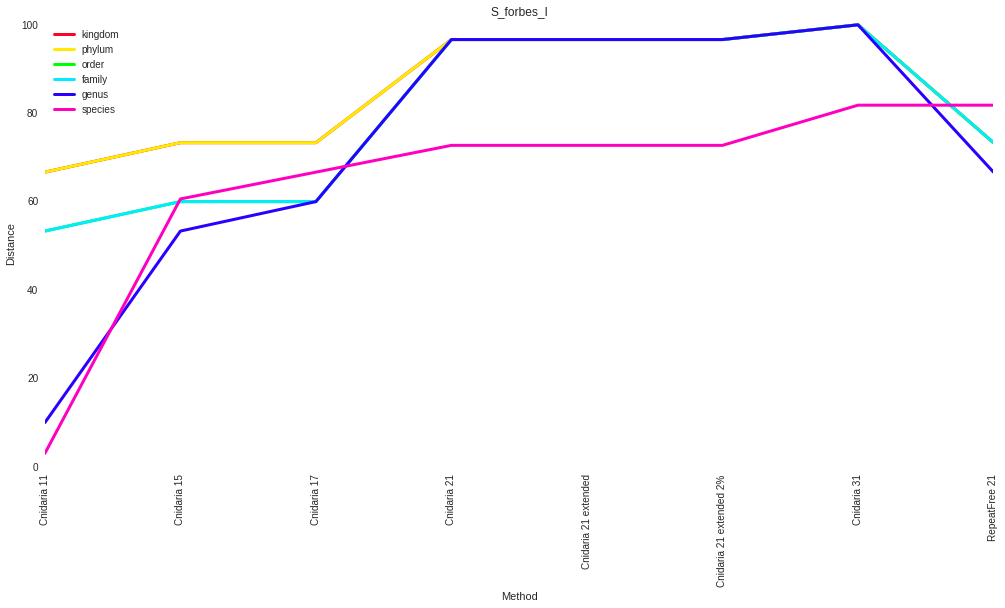

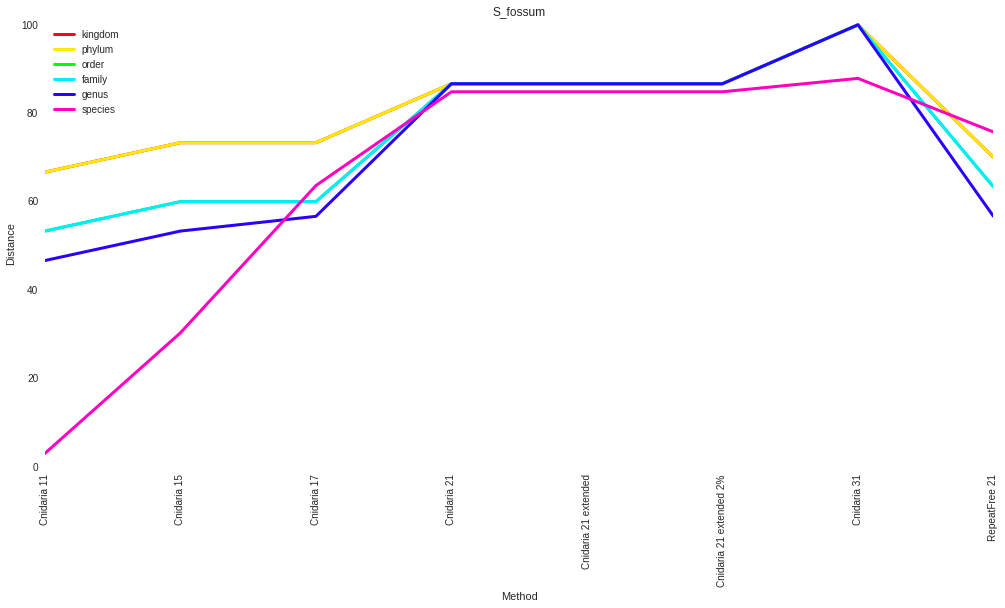

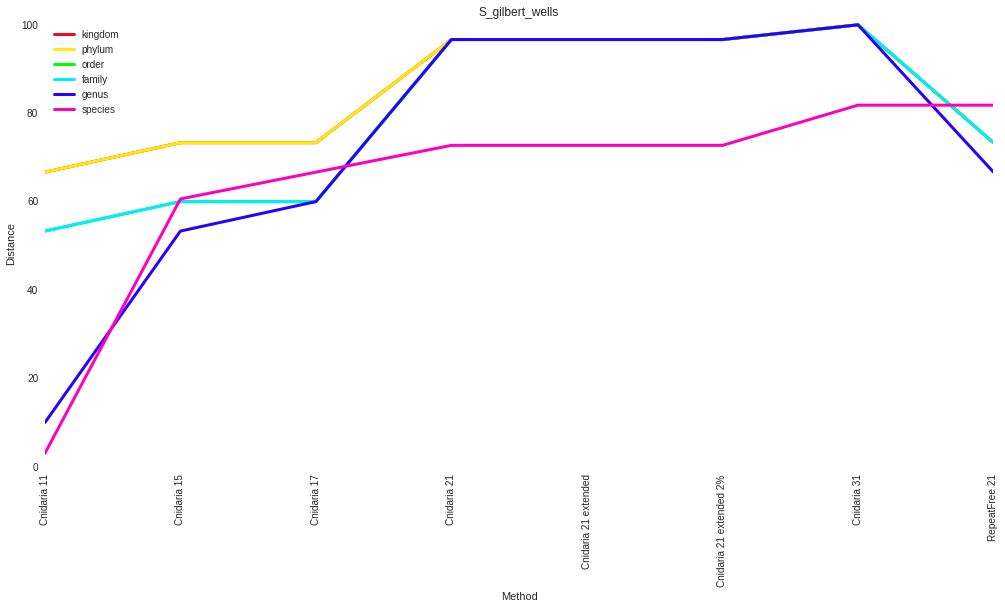

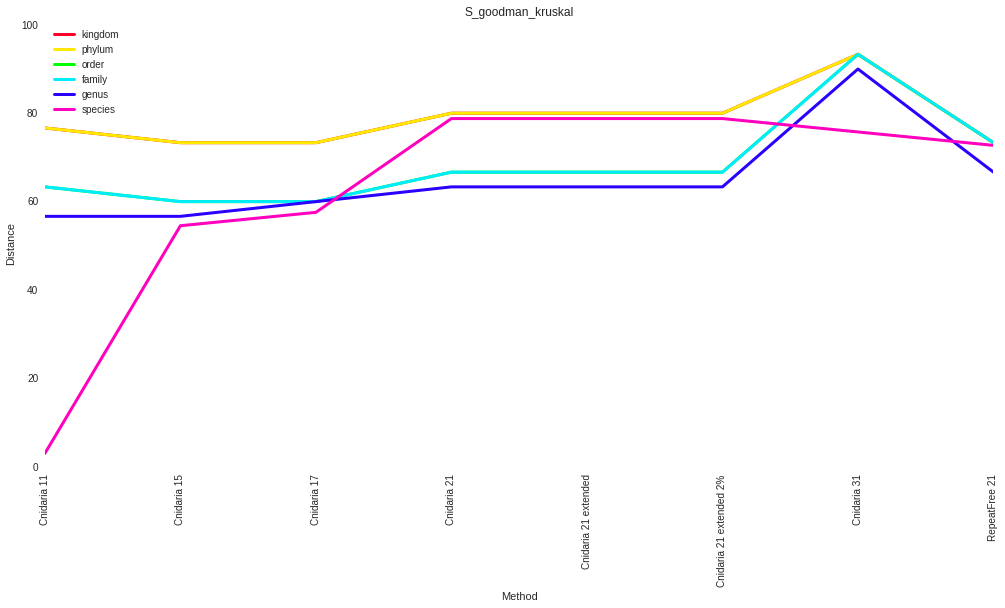

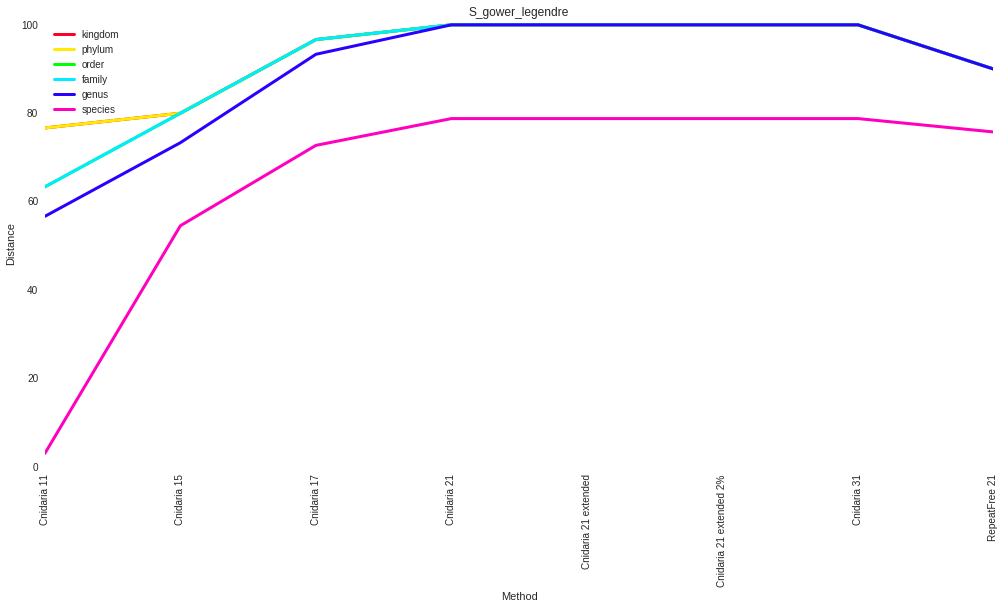

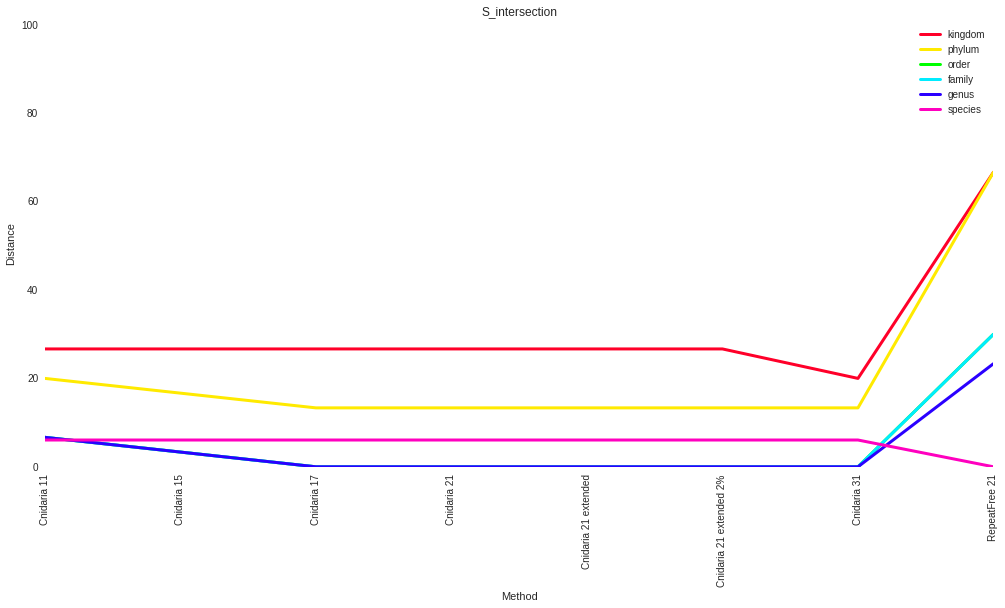

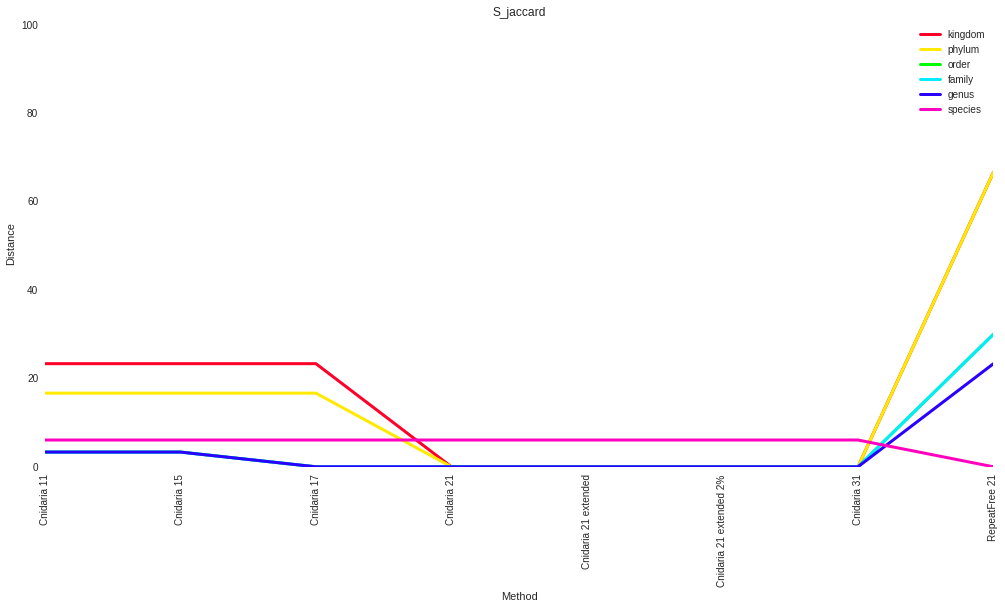

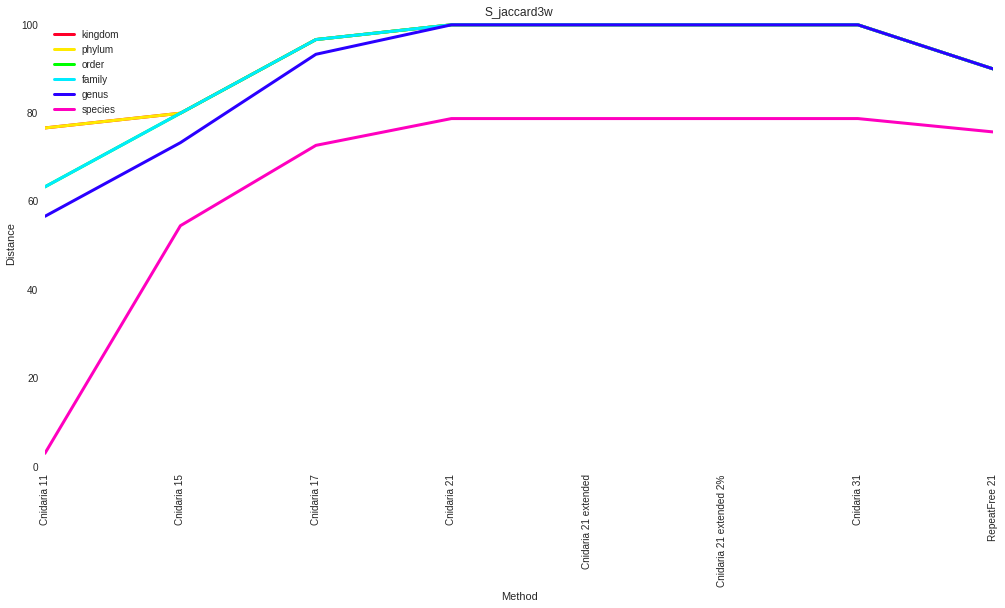

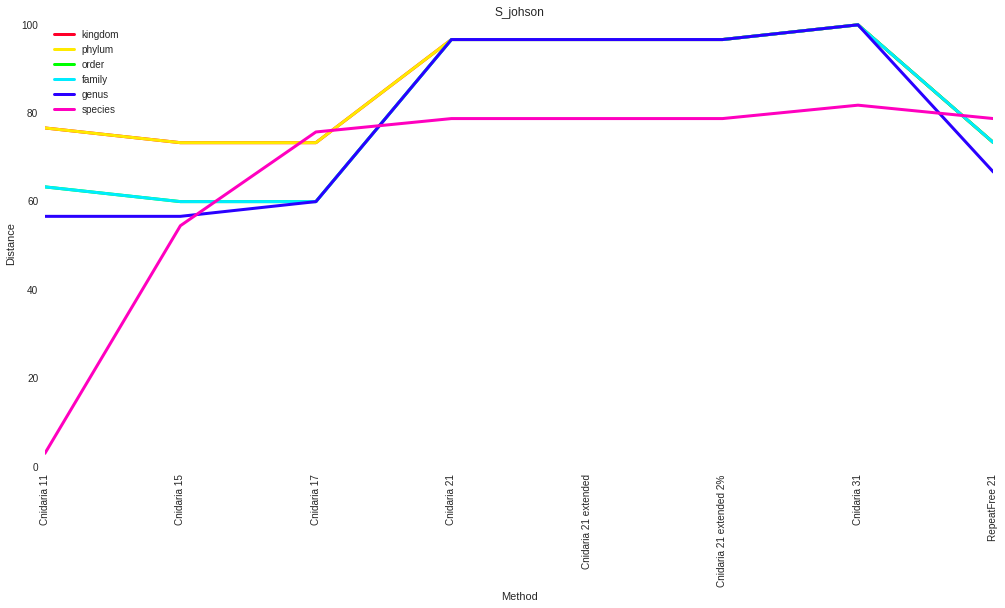

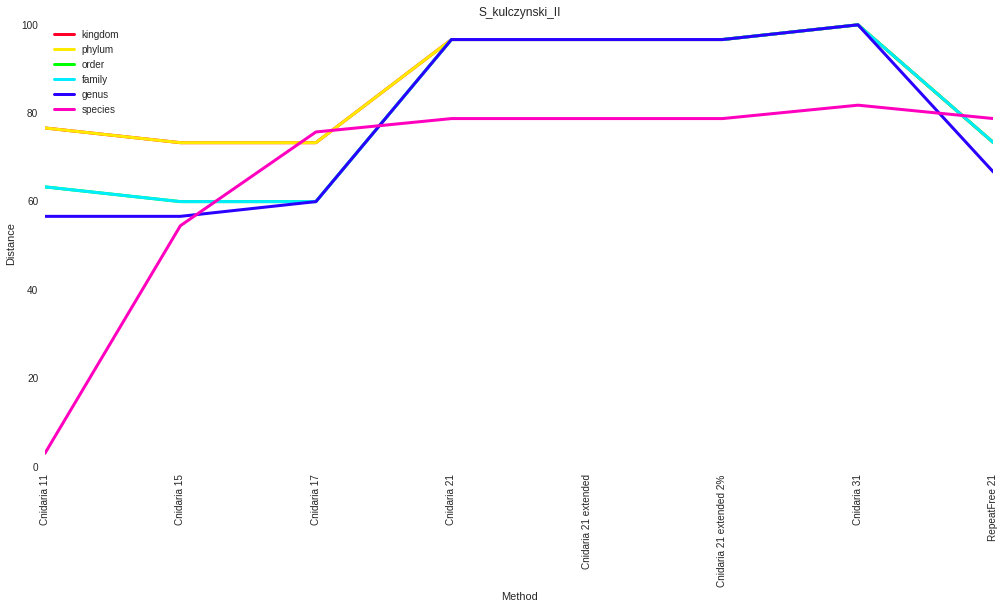

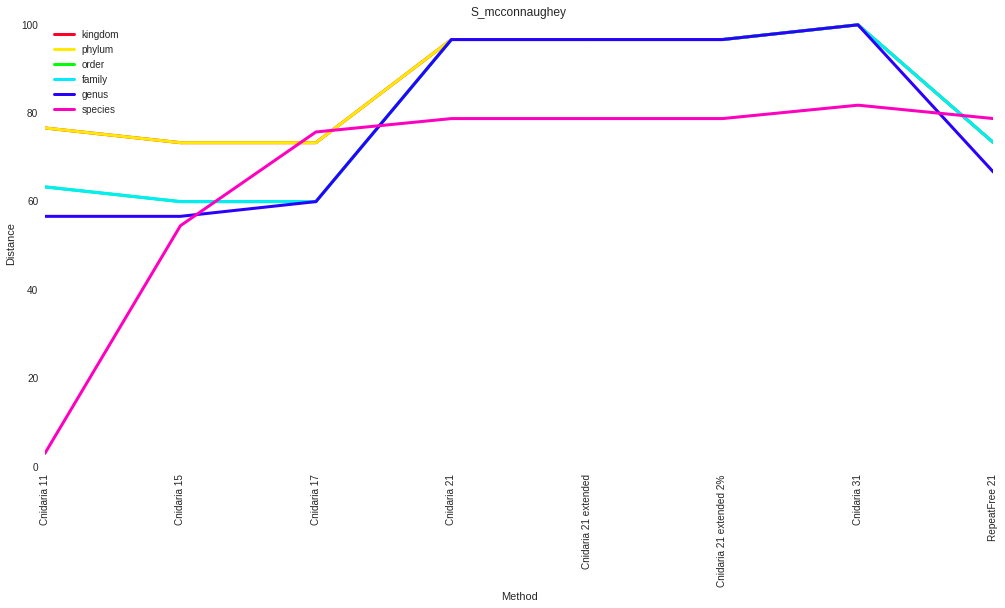

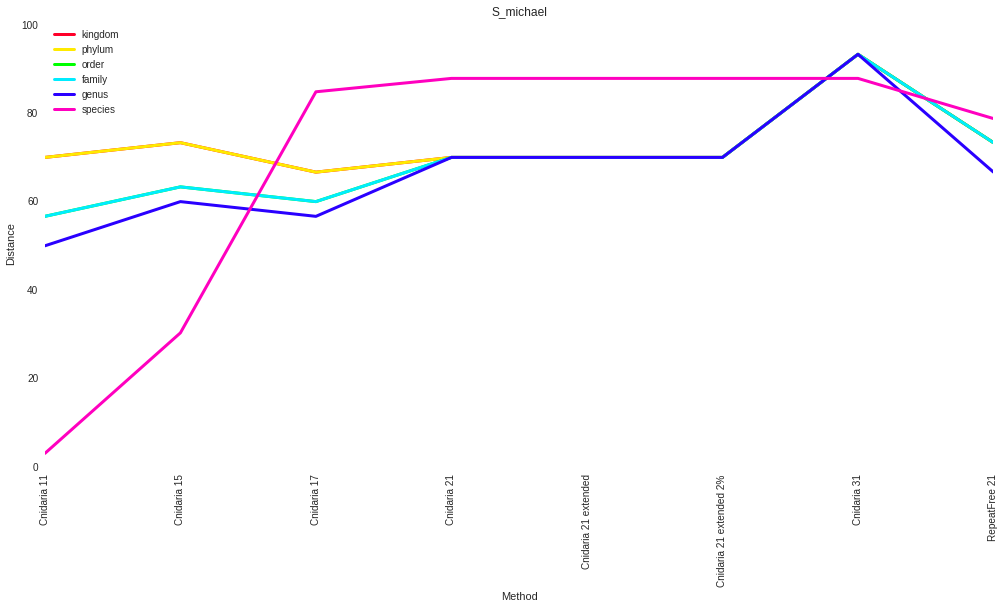

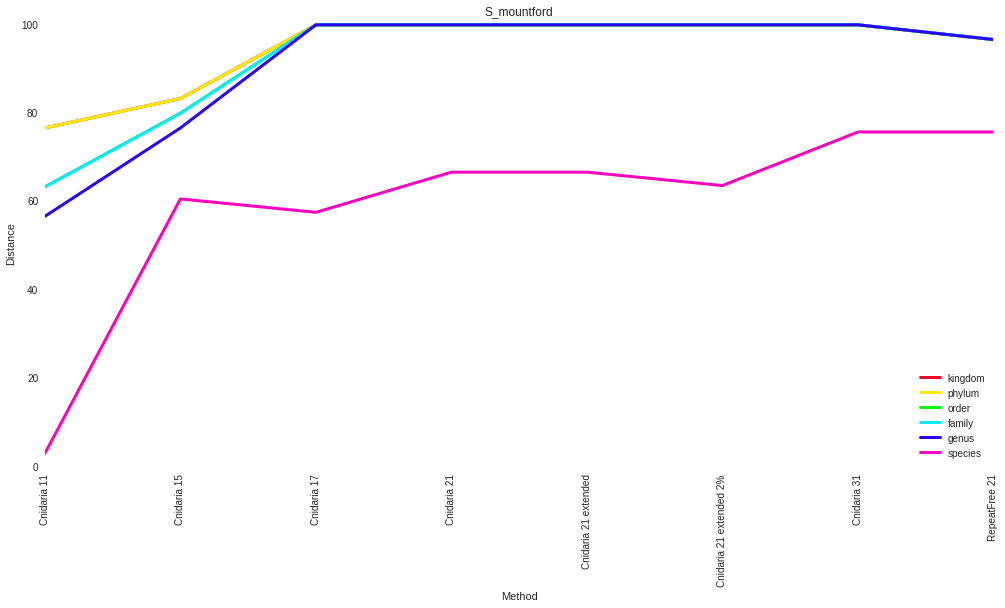

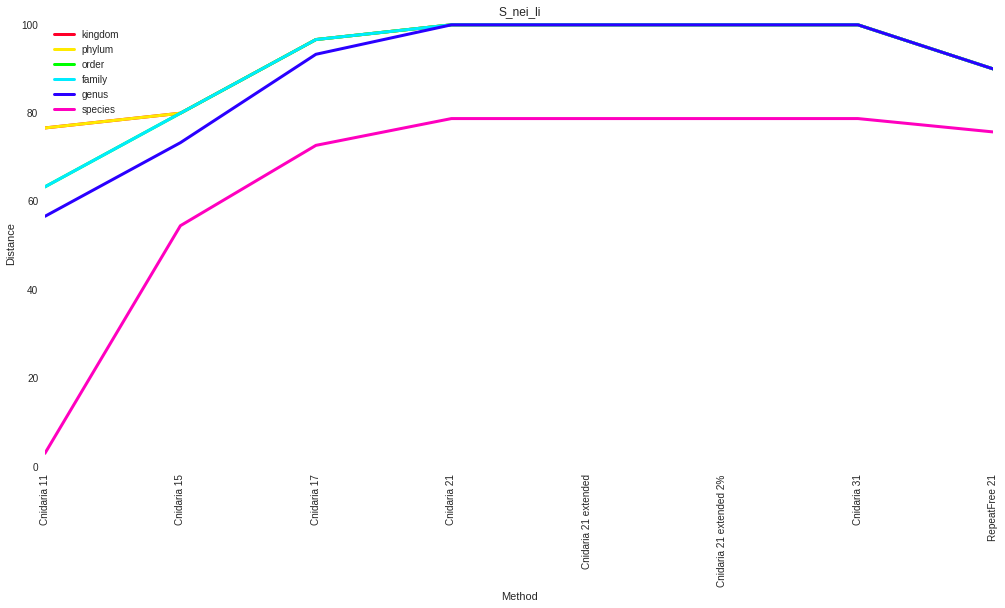

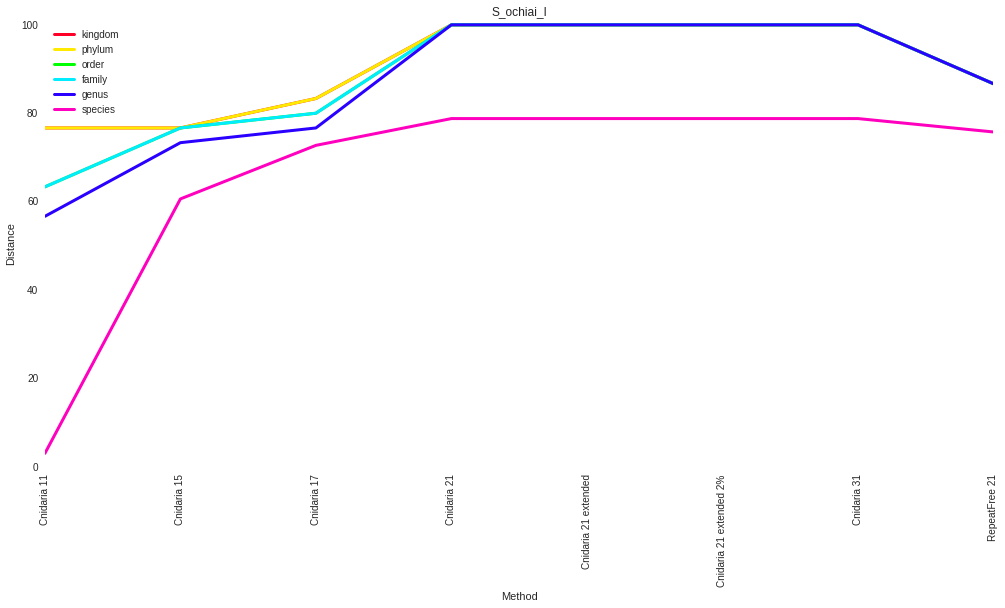

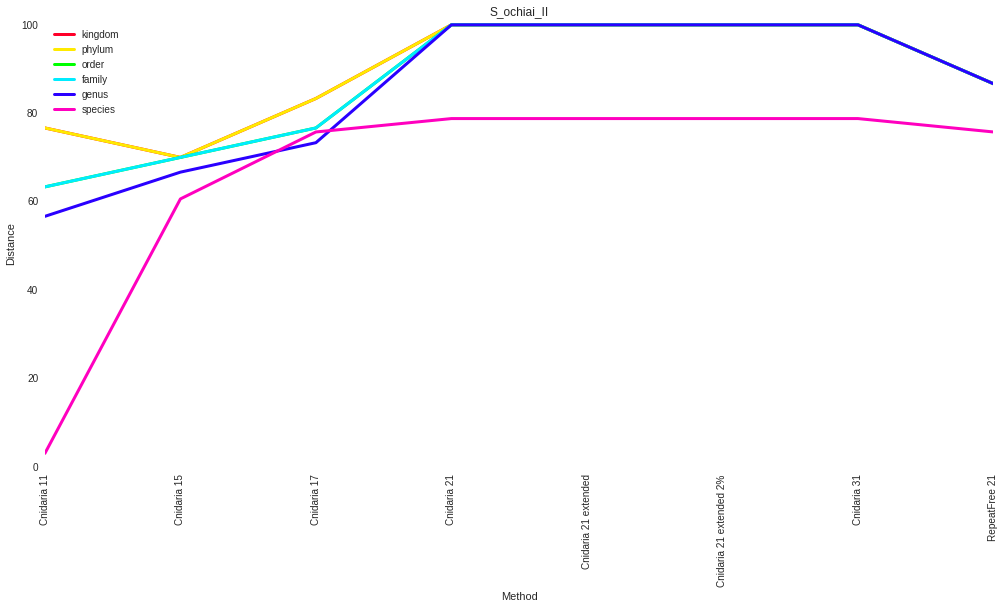

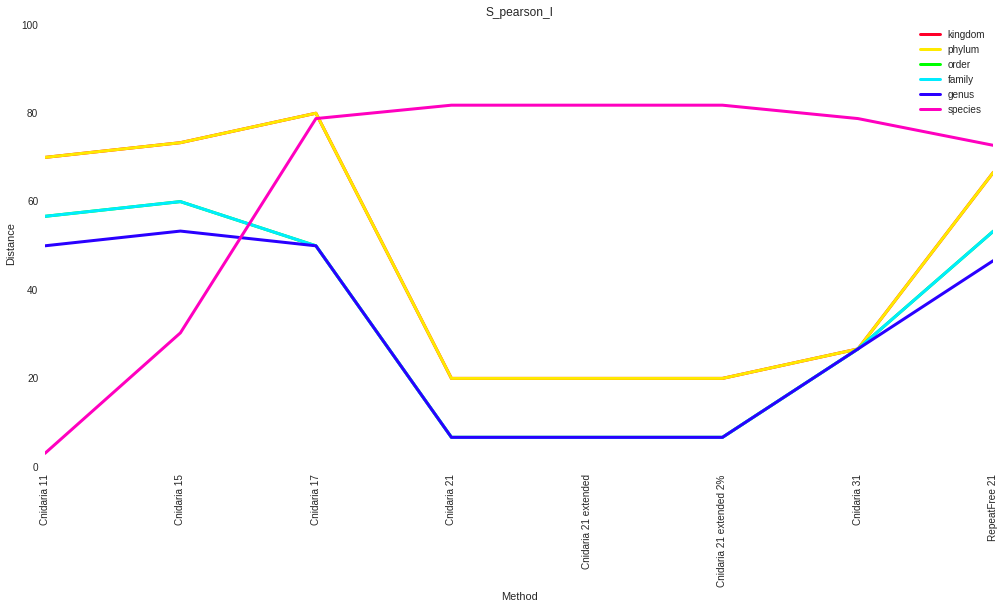

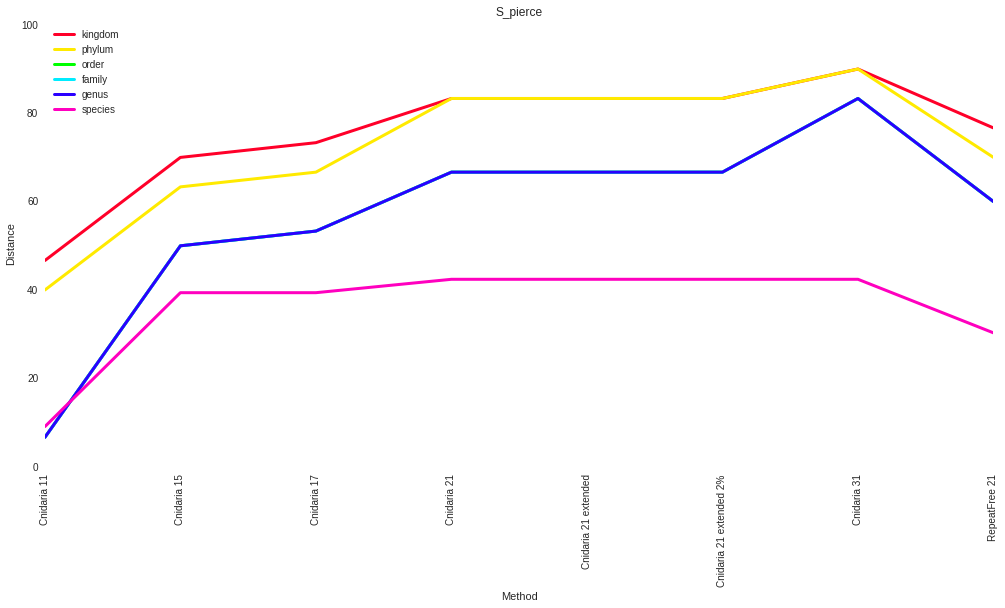

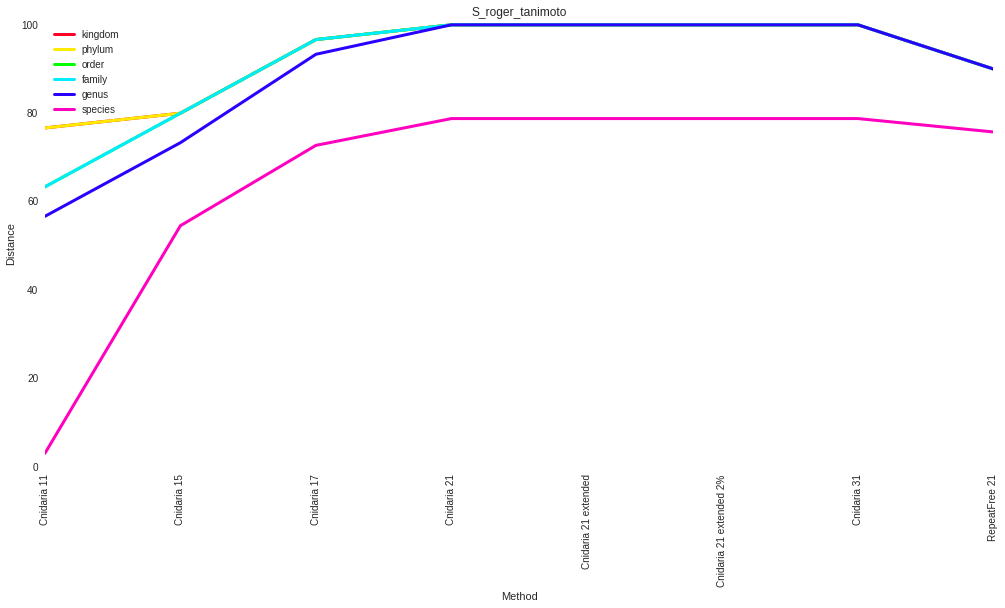

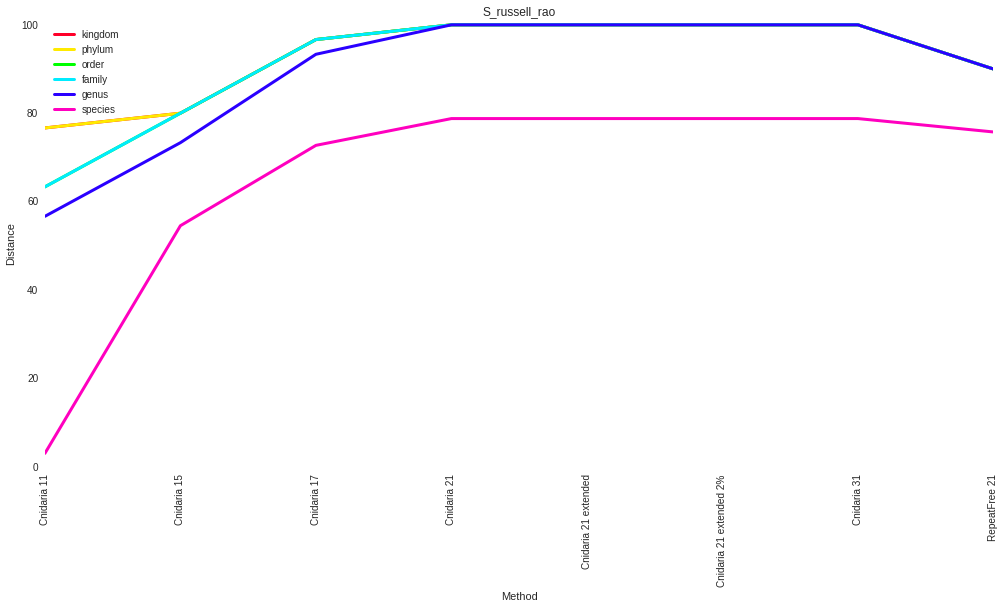

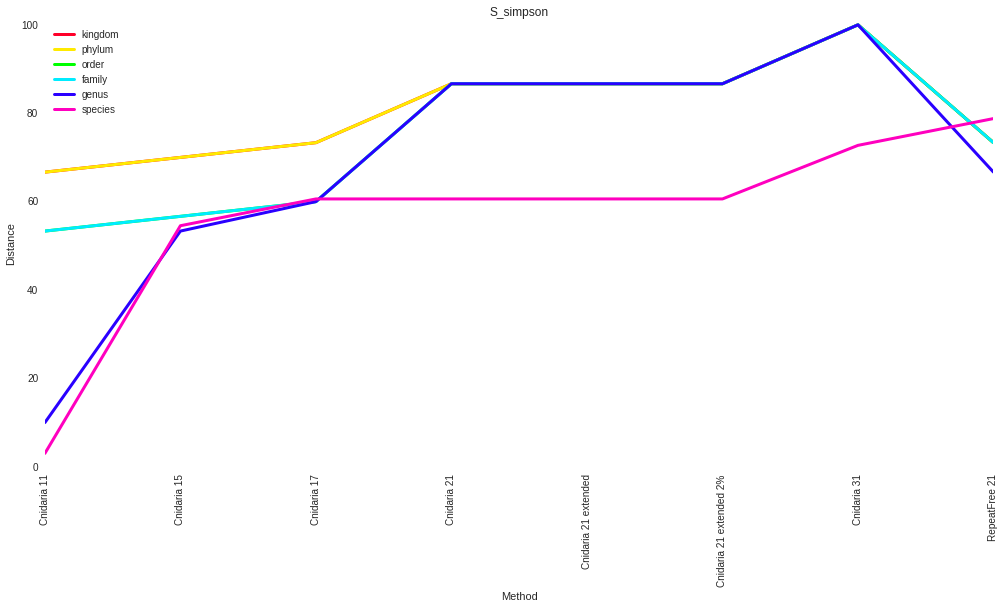

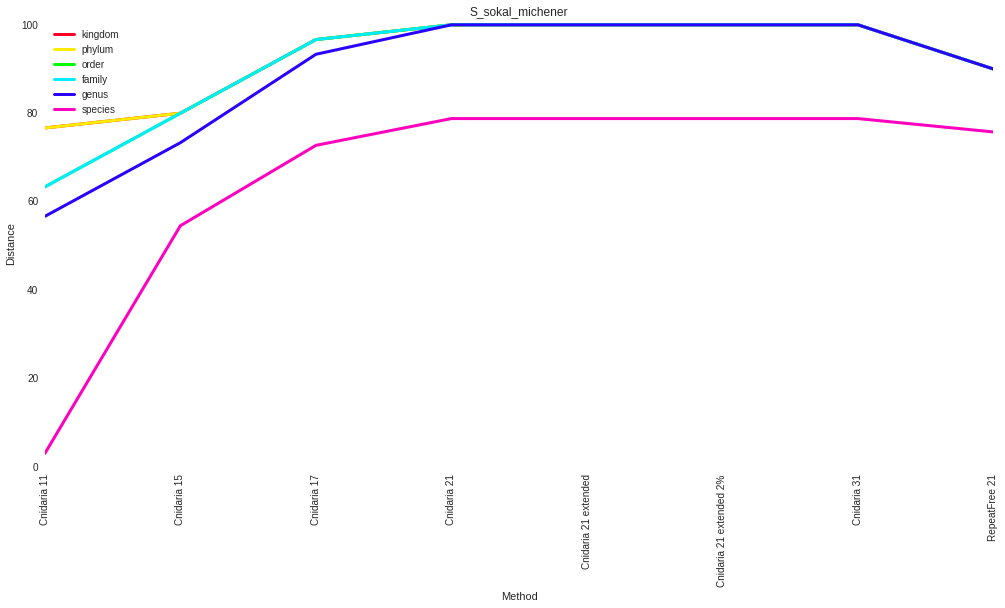

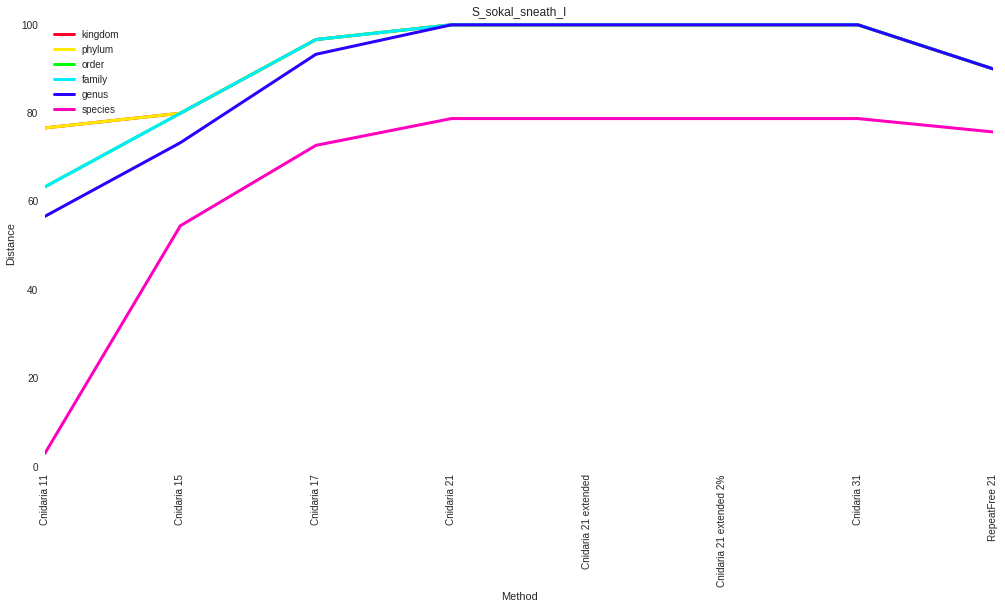

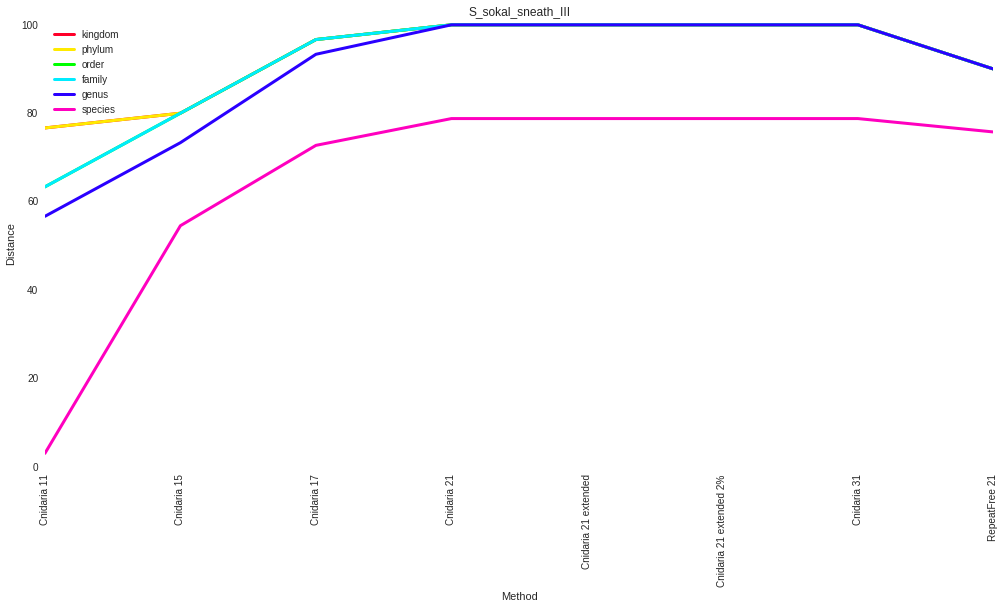

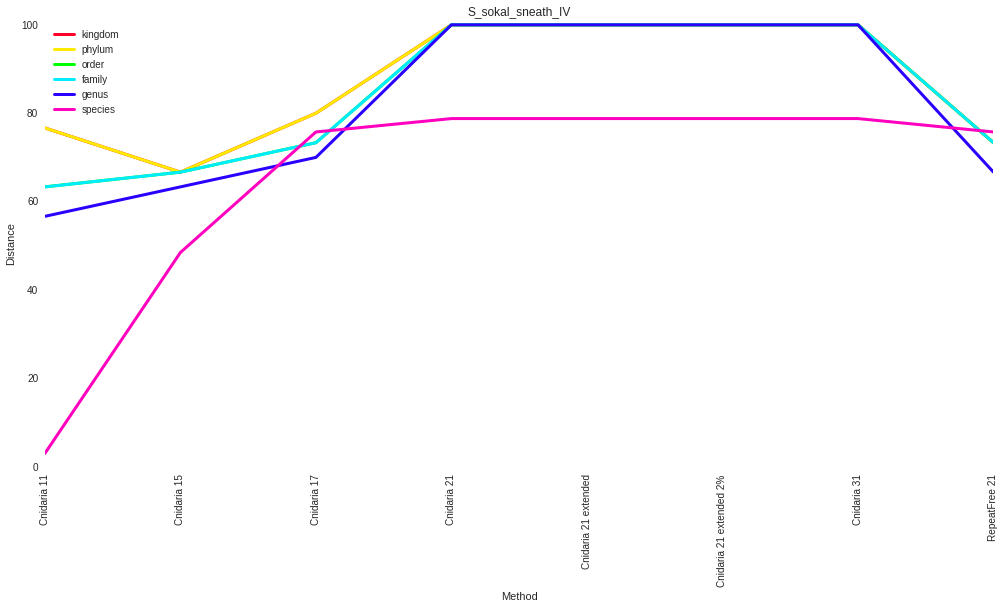

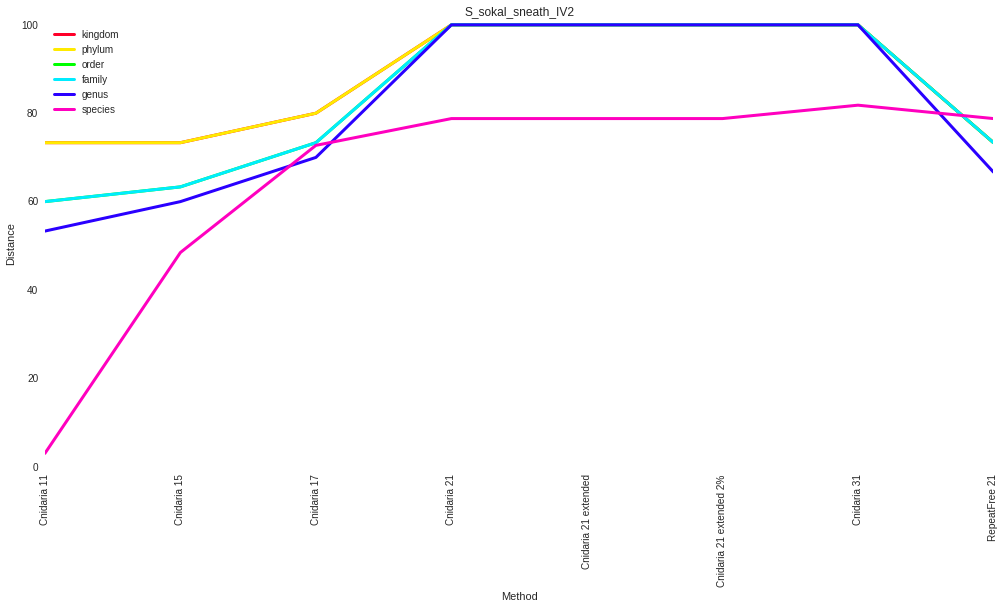

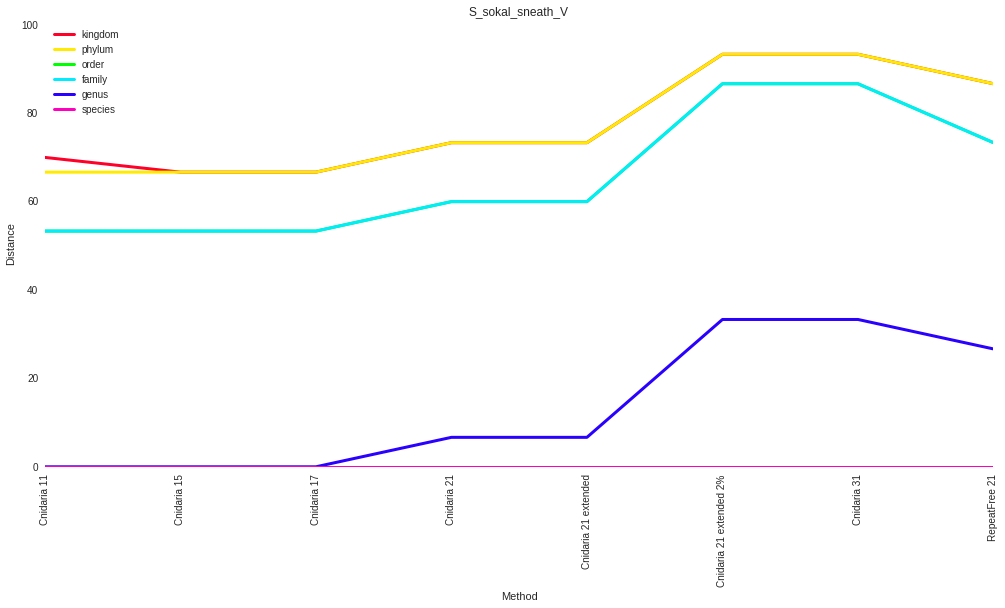

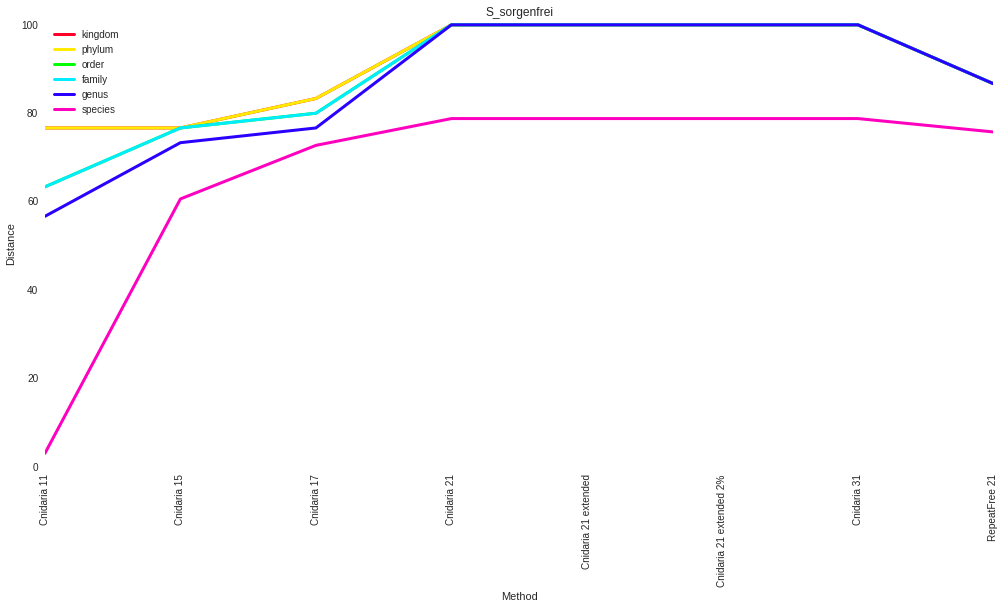

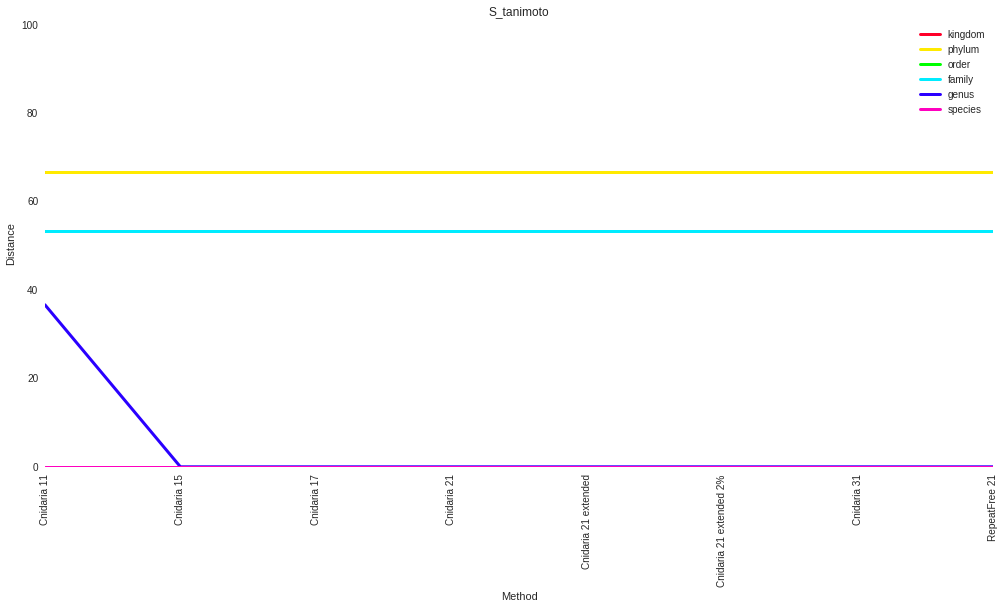

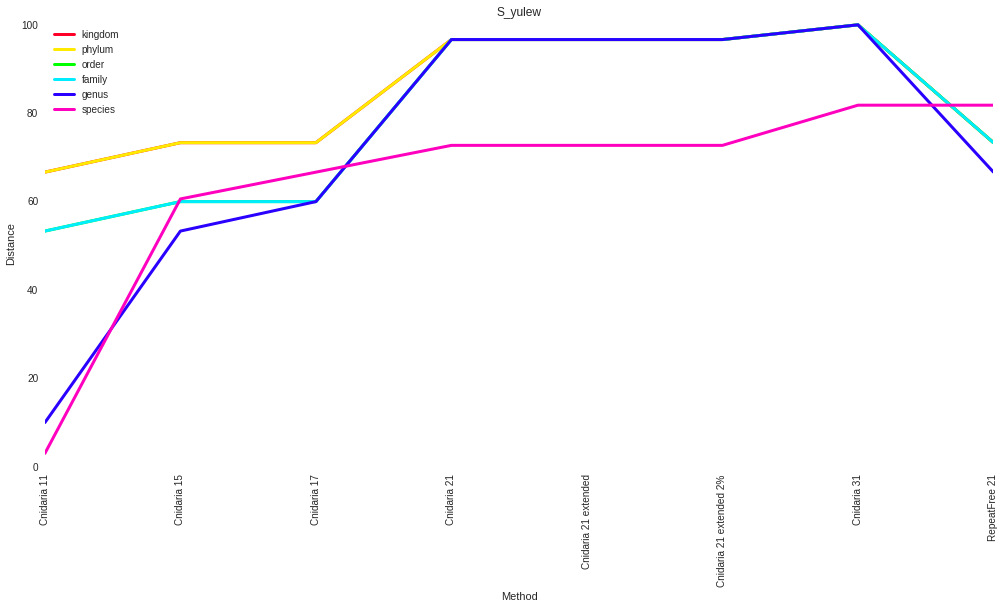

In [507]:
for stat in stats:
    #print stat
    
    stat_data       = pd_data[ (pd_data['statistics'] == stat) ][ ['statistics']+avail_cls ]
    
    #print stat_data.index
    
    stat_data.index = dbs
    
    #display(stat_data)

    pl = stat_data.plot(    lw=3, 
                            colormap='gist_rainbow',
                            #'summer',
                            #'gist_stern', #'hot',#'gist_heat',#'coolwarm',
                            #'cool',#'binary',#'Spectral',#'Reds',
                            #'Purples',#'Greys',#'CMRmap',#'BuPu',
                            #'BrBG',#'Blues',#'Accent',#'winter',
                            #'gist_rainbow',#'Greens',#'cubehelix',#'jet', 
                            #marker='.', 
                            #markersize=10, 
                            title=stat, 
                            figsize=(17, 8), 
                            rot=90, 
                            ylim=(0.0,101.0),
                            #markerfacecolor='lightgrey',
                            #markeredgecolor=None
                       )
    #pl.set_axis_bgcolor('lightgrey')
    pl.set_xlabel("Method"  )
    pl.set_ylabel("Distance")

In [709]:
jaccard = pd_data[ (pd_data['statistics'] == 'D_jaccard') ][ avail_cls ]
jaccard.index = dbs
jaccard

kingdom      phylum       order      family  \
Cnidaria 11               76.666667   76.666667   63.333333   63.333333   
Cnidaria 15               80.000000   80.000000   80.000000   80.000000   
Cnidaria 17               96.666667   96.666667   96.666667   96.666667   
Cnidaria 21              100.000000  100.000000  100.000000  100.000000   
Cnidaria 21 extended     100.000000  100.000000  100.000000  100.000000   
Cnidaria 21 extended 2%  100.000000  100.000000  100.000000  100.000000   
Cnidaria 31              100.000000  100.000000  100.000000  100.000000   
RepeatFree 21             90.000000   90.000000   90.000000   90.000000   

                              genus    species  
Cnidaria 11               56.666667   3.030303  
Cnidaria 15               73.333333  54.545455  
Cnidaria 17               93.333333  72.727273  
Cnidaria 21              100.000000  78.787879  
Cnidaria 21 extended     100.000000  78.787879  
Cnidaria 21 extended 2%  100.000000  78.787879  
Cnidaria 31              100.000000  78.787879  
RepeatFree 21             90.000000  75.757576

In [710]:
min_vals = pd_data.groupby('test_name')[ avail_cls ].min().reset_index()[ avail_cls ]
min_vals.index = dbs
min_vals

kingdom     phylum      order     family  genus  \
Cnidaria 11              23.333333  16.666667   3.333333   3.333333      0   
Cnidaria 15               3.333333   3.333333   0.000000   0.000000      0   
Cnidaria 17               3.333333   3.333333   0.000000   0.000000      0   
Cnidaria 21               0.000000   0.000000   0.000000   0.000000      0   
Cnidaria 21 extended      0.000000   0.000000   0.000000   0.000000      0   
Cnidaria 21 extended 2%   0.000000   0.000000   0.000000   0.000000      0   
Cnidaria 31               0.000000   0.000000   0.000000   0.000000      0   
RepeatFree 21            16.666667  16.666667  10.000000  10.000000      0   

                         species  
Cnidaria 11                    0  
Cnidaria 15                    0  
Cnidaria 17                    0  
Cnidaria 21                    0  
Cnidaria 21 extended           0  
Cnidaria 21 extended 2%        0  
Cnidaria 31                    0  
RepeatFree 21                  0

In [711]:
max_vals = pd_data.groupby('test_name')[ avail_cls ].max().reset_index()[ avail_cls ]
max_vals.index = dbs
max_vals

kingdom      phylum       order      family  \
Cnidaria 11               93.333333   93.333333   80.000000   80.000000   
Cnidaria 15               93.333333   93.333333   93.333333   93.333333   
Cnidaria 17              100.000000  100.000000  100.000000  100.000000   
Cnidaria 21              100.000000  100.000000  100.000000  100.000000   
Cnidaria 21 extended     100.000000  100.000000  100.000000  100.000000   
Cnidaria 21 extended 2%  100.000000  100.000000  100.000000  100.000000   
Cnidaria 31              100.000000  100.000000  100.000000  100.000000   
RepeatFree 21             96.666667   96.666667   96.666667   96.666667   

                              genus    species  
Cnidaria 11               73.333333   9.090909  
Cnidaria 15               86.666667  63.636364  
Cnidaria 17              100.000000  84.848485  
Cnidaria 21              100.000000  87.878788  
Cnidaria 21 extended     100.000000  87.878788  
Cnidaria 21 extended 2%  100.000000  87.878788  
Cnidaria 31              100.000000  87.878788  
RepeatFree 21             96.666667  81.818182

In [698]:
cs = cm.ScalarMappable(norm=None, cmap='gist_rainbow')
cs.set_clim(0, len(dbs))

x = np.array(range(len(avail_cls)))

f, axarr = plt.subplots(len(dbs), sharex=True)

f.set_size_inches(17, 16)

for row_name in dbs:
    jac_row_index = list(jaccard.index).index(row_name)
    color         = cs.to_rgba(row_index)
    
    jac_row       = np.array(jaccard[  jac_row_index:jac_row_index+1 ].reset_index()[ avail_cls ])[0]
    jac_min_row   = np.array(min_vals[ jac_row_index:jac_row_index+1 ].reset_index()[ avail_cls ])[0]
    jac_max_row   = np.array(max_vals[ jac_row_index:jac_row_index+1 ].reset_index()[ avail_cls ])[0]
    
    rplt = axarr[jac_row_index]
    
    rplt.plot(x, jac_row, label=row_name, color=color, linewidth=3)
    rplt.set_title(row_name)
    rplt.fill_between(x, jac_min_row, jac_max_row, color=color, alpha=0.3)
    rplt.set_ylim(0,101.0)
    rplt.yaxis.set_ticks([0,50,100])
    
    for item in ([  rplt.title,              
                    rplt.xaxis.label, 
                    rplt.yaxis.label] +
                    rplt.get_xticklabels() + 
                    rplt.get_yticklabels()):
        item.set_fontsize(15)
    
plt.xticks(x, avail_cls, rotation=45)

plt.show()

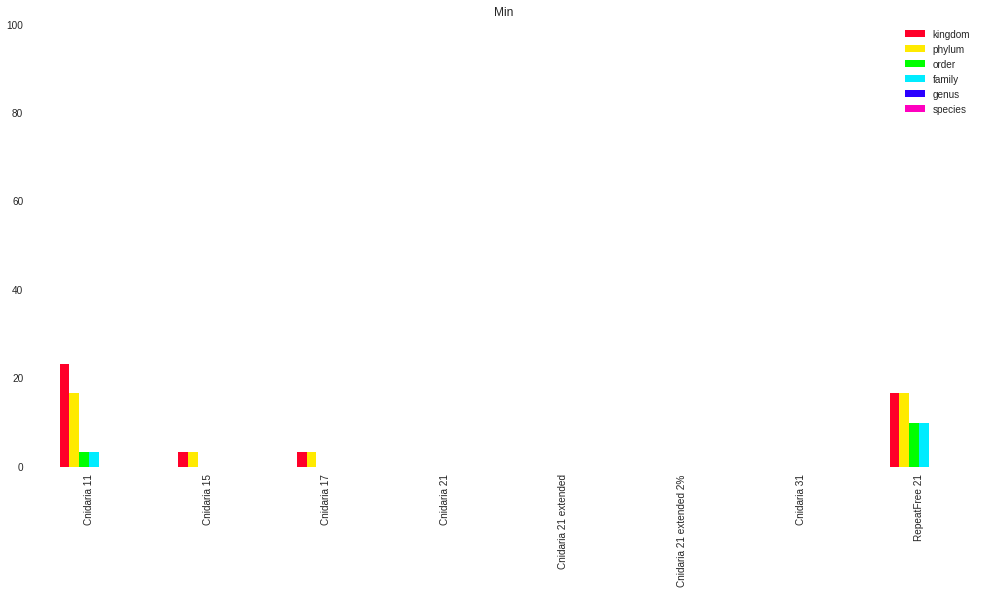

In [636]:
pl = jaccard.plot(  lw=0,
                    kind='bar',
                    colormap='gist_rainbow',
                    #'summer',
                    #'gist_stern', #'hot',#'gist_heat',#'coolwarm',
                    #'cool',#'binary',#'Spectral',#'Reds',
                    #'Purples',#'Greys',#'CMRmap',#'BuPu',
                    #'BrBG',#'Blues',#'Accent',#'winter',
                    #'gist_rainbow',#'Greens',#'cubehelix',#'jet', 
                    #marker='.', 
                    #markersize=10, 
                    title='Jaccard', 
                    figsize=(17, 8), 
                    rot=90, 
                    ylim=(0.0,101.0),
                    #markerfacecolor='lightgrey',
                    #markeredgecolor=None
                )

pl = min_vals.plot( lw=0,
                    kind='bar',
                    colormap='gist_rainbow',
                    #'summer',
                    #'gist_stern', #'hot',#'gist_heat',#'coolwarm',
                    #'cool',#'binary',#'Spectral',#'Reds',
                    #'Purples',#'Greys',#'CMRmap',#'BuPu',
                    #'BrBG',#'Blues',#'Accent',#'winter',
                    #'gist_rainbow',#'Greens',#'cubehelix',#'jet', 
                    #marker='.', 
                    #markersize=10, 
                    title='Min', 
                    figsize=(17, 8), 
                    rot=90, 
                    ylim=(0.0,101.0),
                    #markerfacecolor='lightgrey',
                    #markeredgecolor=None
                )

pl = max_vals.plot( lw=0,
                    kind='bar',
                    colormap='gist_rainbow',
                    #'summer',
                    #'gist_stern', #'hot',#'gist_heat',#'coolwarm',
                    #'cool',#'binary',#'Spectral',#'Reds',
                    #'Purples',#'Greys',#'CMRmap',#'BuPu',
                    #'BrBG',#'Blues',#'Accent',#'winter',
                    #'gist_rainbow',#'Greens',#'cubehelix',#'jet', 
                    #marker='.', 
                    #markersize=10, 
                    title='Max', 
                    figsize=(17, 8), 
                    rot=90, 
                    ylim=(0.0,101.0),
                    #markerfacecolor='lightgrey',
                    #markeredgecolor=None
                )

In [637]:
res = pd.concat([jaccard, min_vals, max_vals], keys=['Jaccard', 'Min', 'Max'], join='inner', axis=0)
res

kingdom      phylum       order  \
Jaccard Cnidaria 11               76.666667   76.666667   63.333333   
        Cnidaria 15               80.000000   80.000000   80.000000   
        Cnidaria 17               96.666667   96.666667   96.666667   
        Cnidaria 21              100.000000  100.000000  100.000000   
        Cnidaria 21 extended     100.000000  100.000000  100.000000   
        Cnidaria 21 extended 2%  100.000000  100.000000  100.000000   
        Cnidaria 31              100.000000  100.000000  100.000000   
        RepeatFree 21             90.000000   90.000000   90.000000   
Min     Cnidaria 11               23.333333   16.666667    3.333333   
        Cnidaria 15                3.333333    3.333333    0.000000   
        Cnidaria 17                3.333333    3.333333    0.000000   
        Cnidaria 21                0.000000    0.000000    0.000000   
        Cnidaria 21 extended       0.000000    0.000000    0.000000   
        Cnidaria 21 extended 2%    0.000000    0.000000    0.000000   
        Cnidaria 31                0.000000    0.000000    0.000000   
        RepeatFree 21             16.666667   16.666667   10.000000   
Max     Cnidaria 11               93.333333   93.333333   80.000000   
        Cnidaria 15               93.333333   93.333333   93.333333   
        Cnidaria 17              100.000000  100.000000  100.000000   
        Cnidaria 21              100.000000  100.000000  100.000000   
        Cnidaria 21 extended     100.000000  100.000000  100.000000   
        Cnidaria 21 extended 2%  100.000000  100.000000  100.000000   
        Cnidaria 31              100.000000  100.000000  100.000000   
        RepeatFree 21             96.666667   96.666667   96.666667   

                                     family       genus    species  
Jaccard Cnidaria 11               63.333333   56.666667   3.030303  
        Cnidaria 15               80.000000   73.333333  54.545455  
        Cnidaria 17               96.666667   93.333333  72.727273  
        Cnidaria 21              100.000000  100.000000  78.787879  
        Cnidaria 21 extended     100.000000  100.000000  78.787879  
        Cnidaria 21 extended 2%  100.000000  100.000000  78.787879  
        Cnidaria 31              100.000000  100.000000  78.787879  
        RepeatFree 21             90.000000   90.000000  75.757576  
Min     Cnidaria 11                3.333333    0.000000   0.000000  
        Cnidaria 15                0.000000    0.000000   0.000000  
        Cnidaria 17                0.000000    0.000000   0.000000  
        Cnidaria 21                0.000000    0.000000   0.000000  
        Cnidaria 21 extended       0.000000    0.000000   0.000000  
        Cnidaria 21 extended 2%    0.000000    0.000000   0.000000  
        Cnidaria 31                0.000000    0.000000   0.000000  
        RepeatFree 21             10.000000    0.000000   0.000000  
Max     Cnidaria 11               80.000000   73.333333   9.090909  
        Cnidaria 15               93.333333   86.666667  63.636364  
        Cnidaria 17              100.000000  100.000000  84.848485  
        Cnidaria 21              100.000000  100.000000  87.878788  
        Cnidaria 21 extended     100.000000  100.000000  87.878788  
        Cnidaria 21 extended 2%  100.000000  100.000000  87.878788  
        Cnidaria 31              100.000000  100.000000  87.878788  
        RepeatFree 21             96.666667   96.666667  81.818182

In [516]:
res2 = res.copy()

lvl1 = res2.index.levels[0]
lvl2 = res2.index.levels[1]

val1 = ",".join([ ",".join([x]*len(lvl2)) for x in lvl1 ]).split(',')
val2 = ",".join([ ",".join([x]*len(lvl1)) for x in lvl2 ]).split(',')

res2['class'] = val1
res2['stats'] = val2

res2

kingdom      phylum       order  \
Jaccard Cnidaria 11               76.666667   76.666667   63.333333   
        Cnidaria 15               80.000000   80.000000   80.000000   
        Cnidaria 17               96.666667   96.666667   96.666667   
        Cnidaria 21              100.000000  100.000000  100.000000   
        Cnidaria 21 extended     100.000000  100.000000  100.000000   
        Cnidaria 21 extended 2%  100.000000  100.000000  100.000000   
        Cnidaria 31              100.000000  100.000000  100.000000   
        RepeatFree 21             90.000000   90.000000   90.000000   
Min     Cnidaria 11               23.333333   16.666667    3.333333   
        Cnidaria 15                3.333333    3.333333    0.000000   
        Cnidaria 17                3.333333    3.333333    0.000000   
        Cnidaria 21                0.000000    0.000000    0.000000   
        Cnidaria 21 extended       0.000000    0.000000    0.000000   
        Cnidaria 21 extended 2%    0.000000    0.000000    0.000000   
        Cnidaria 31                0.000000    0.000000    0.000000   
        RepeatFree 21             16.666667   16.666667   10.000000   
Max     Cnidaria 11               93.333333   93.333333   80.000000   
        Cnidaria 15               93.333333   93.333333   93.333333   
        Cnidaria 17              100.000000  100.000000  100.000000   
        Cnidaria 21              100.000000  100.000000  100.000000   
        Cnidaria 21 extended     100.000000  100.000000  100.000000   
        Cnidaria 21 extended 2%  100.000000  100.000000  100.000000   
        Cnidaria 31              100.000000  100.000000  100.000000   
        RepeatFree 21             96.666667   96.666667   96.666667   

                                     family       genus    species    class  \
Jaccard Cnidaria 11               63.333333   56.666667   3.030303  Jaccard   
        Cnidaria 15               80.000000   73.333333  54.545455  Jaccard   
        Cnidaria 17               96.666667   93.333333  72.727273  Jaccard   
        Cnidaria 21              100.000000  100.000000  78.787879  Jaccard   
        Cnidaria 21 extended     100.000000  100.000000  78.787879  Jaccard   
        Cnidaria 21 extended 2%  100.000000  100.000000  78.787879  Jaccard   
        Cnidaria 31              100.000000  100.000000  78.787879  Jaccard   
        RepeatFree 21             90.000000   90.000000  75.757576  Jaccard   
Min     Cnidaria 11                3.333333    0.000000   0.000000      Min   
        Cnidaria 15                0.000000    0.000000   0.000000      Min   
        Cnidaria 17                0.000000    0.000000   0.000000      Min   
        Cnidaria 21                0.000000    0.000000   0.000000      Min   
        Cnidaria 21 extended       0.000000    0.000000   0.000000      Min   
        Cnidaria 21 extended 2%    0.000000    0.000000   0.000000      Min   
        Cnidaria 31                0.000000    0.000000   0.000000      Min   
        RepeatFree 21             10.000000    0.000000   0.000000      Min   
Max     Cnidaria 11               80.000000   73.333333   9.090909      Max   
        Cnidaria 15               93.333333   86.666667  63.636364      Max   
        Cnidaria 17              100.000000  100.000000  84.848485      Max   
        Cnidaria 21              100.000000  100.000000  87.878788      Max   
        Cnidaria 21 extended     100.000000  100.000000  87.878788      Max   
        Cnidaria 21 extended 2%  100.000000  100.000000  87.878788      Max   
        Cnidaria 31              100.000000  100.000000  87.878788      Max   
        RepeatFree 21             96.666667   96.666667  81.818182      Max   

                                                   stats  
Jaccard Cnidaria 11                          Cnidaria 11  
        Cnidaria 15                          Cnidaria 11  
        Cnidaria 17                          Cnidaria 11  
        Cnidaria 21                          Cni

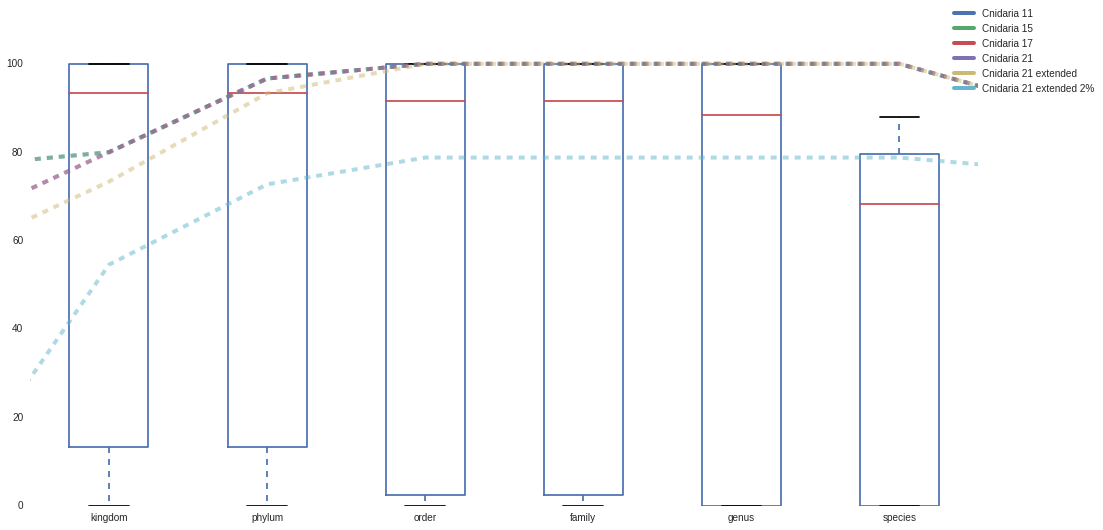

In [517]:
fig, ax = plt.subplots(figsize=(17, 8), dpi=600)
plt.ylim(0.0,101.0)
res.boxplot()
fig2 = plt.plot(jaccard, '--', alpha=0.5, label=jaccard.index, linewidth=4.0)
plt.figlegend(ax2, jaccard.index, 'upper right')
plt.show()
plt.close()

In [ ]:
"""
pl = stat_data.plot(    lw=3, 
                        colormap='gist_rainbow',
                        #'summer',
                        #'gist_stern', #'hot',#'gist_heat',#'coolwarm',
                        #'cool',#'binary',#'Spectral',#'Reds',
                        #'Purples',#'Greys',#'CMRmap',#'BuPu',
                        #'BrBG',#'Blues',#'Accent',#'winter',
                        #'gist_rainbow',#'Greens',#'cubehelix',#'jet', 
                        #marker='.', 
                        #markersize=10, 
                        title=stat, 
                        figsize=(17, 8), 
                        rot=90, 
                        ylim=(0.0,1.0),
                        #markerfacecolor='lightgrey',
                        #markeredgecolor=None
                   )
pl.set_axis_bgcolor('lightgrey')
pl.set_xlabel("Method"  )
pl.set_ylabel("Distance")
"""

In [518]:
jaccard2 = jaccard
jaccard2['Name'] = jaccard.index
jaccard2

kingdom      phylum       order      family  \
Cnidaria 11               76.666667   76.666667   63.333333   63.333333   
Cnidaria 15               80.000000   80.000000   80.000000   80.000000   
Cnidaria 17               96.666667   96.666667   96.666667   96.666667   
Cnidaria 21              100.000000  100.000000  100.000000  100.000000   
Cnidaria 21 extended     100.000000  100.000000  100.000000  100.000000   
Cnidaria 21 extended 2%  100.000000  100.000000  100.000000  100.000000   
Cnidaria 31              100.000000  100.000000  100.000000  100.000000   
RepeatFree 21             90.000000   90.000000   90.000000   90.000000   

                              genus    species                     Name  
Cnidaria 11               56.666667   3.030303              Cnidaria 11  
Cnidaria 15               73.333333  54.545455              Cnidaria 15  
Cnidaria 17               93.333333  72.727273              Cnidaria 17  
Cnidaria 21              100.000000  78.787879              Cnidaria 21  
Cnidaria 21 extended     100.000000  78.787879     Cnidaria 21 extended  
Cnidaria 21 extended 2%  100.000000  78.787879  Cnidaria 21 extended 2%  
Cnidaria 31              100.000000  78.787879              Cnidaria 31  
RepeatFree 21             90.000000  75.757576            RepeatFree 21

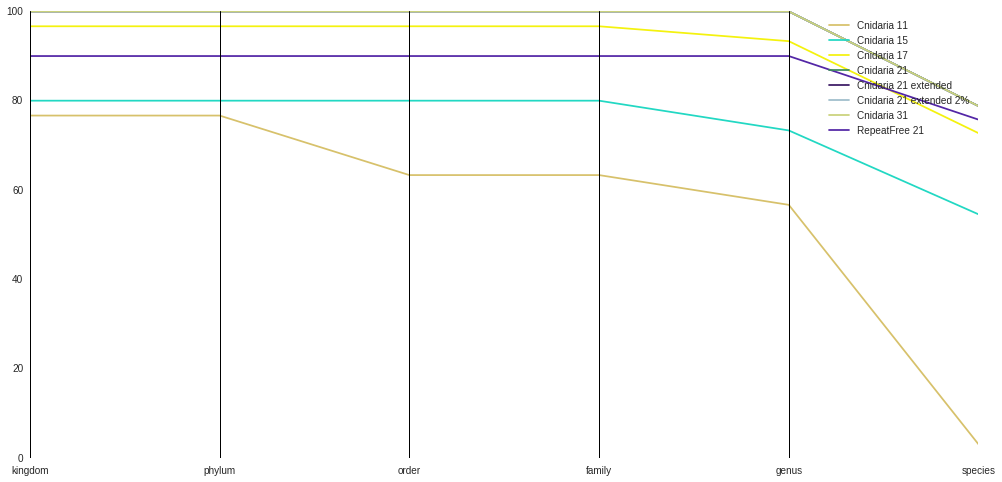

In [519]:
plt.figure(figsize=(17, 8))
parallel_coordinates(jaccard2, 'Name')
plt.show()
plt.close()

In [520]:
plt.figure(figsize=(17, 8))
res['Name'] = res.index
parallel_coordinates(res, 'Name')
plt.show()
plt.close()

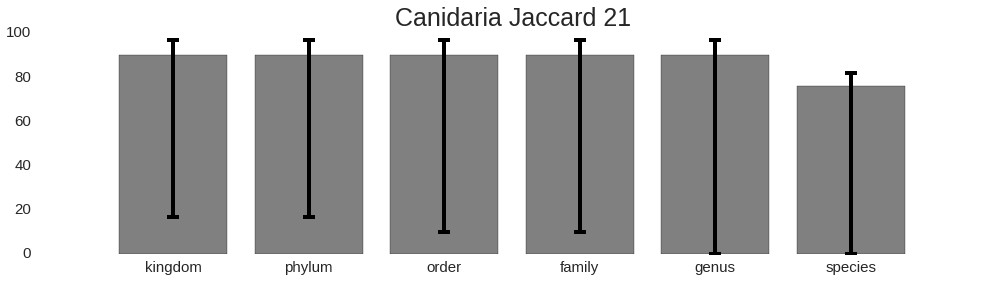

In [654]:
fig, ax   = plt.subplots()

fig.set_size_inches(17, 4)

jac_row_name  = 'Cnidaria 21'
jac_row_index = list(jaccard.index).index(row_name)

jac_row   = np.array(jaccard[  jac_row_index:jac_row_index+1 ].reset_index()[ avail_cls ])[0]
jac_row   = np.array(jaccard[  jac_row_index:jac_row_index+1 ].reset_index()[ avail_cls ])[0]

min_row   = np.array(min_vals[ jac_row_index:jac_row_index+1 ].reset_index()[ avail_cls ])[0]
max_row   = np.array(max_vals[ jac_row_index:jac_row_index+1 ].reset_index()[ avail_cls ])[0]

ax.bar(
        range(len(avail_cls)), 
        jac_row, 
        color    = 'grey', 
        yerr     = (jac_row-min_row,max_row-jac_row),
        error_kw = dict(ecolor='black', lw=4, capsize=6, capthick=4),
        align    = 'center'
        )

ax.set_title('Canidaria Jaccard 21')
ax.set_ylim(0,101.0)

for item in ([  ax.title,              
                ax.xaxis.label, 
                ax.yaxis.label]      +
                ax.get_xticklabels() + 
                ax.get_yticklabels()
            ):
    item.set_fontsize(15)

ax.title.set_fontsize(25)

plt.xticks(range(len(avail_cls)), avail_cls)#, rotation=45)

plt.show()
plt.close()

In [745]:
fig, ax   = plt.subplots()

fig.set_size_inches(14, 4)

cni_row_name  = 'Cnidaria 21'
cni_row_index = list(jaccard.index).index(cni_row_name)
cni_row       = np.array(jaccard[  cni_row_index:cni_row_index+1 ].reset_index()[ avail_cls ])[0]
cni_min_row   = np.array(min_vals[ cni_row_index:cni_row_index+1 ].reset_index()[ avail_cls ])[0]
cni_max_row   = np.array(max_vals[ cni_row_index:cni_row_index+1 ].reset_index()[ avail_cls ])[0]

ref_row_name  = 'RepeatFree 21'
ref_row_index = list(jaccard.index).index(ref_row_name)
ref_row       = np.array(jaccard[  ref_row_index:ref_row_index+1 ].reset_index()[ avail_cls ])[0]
ref_min_row   = np.array(min_vals[ ref_row_index:ref_row_index+1 ].reset_index()[ avail_cls ])[0]
ref_max_row   = np.array(max_vals[ ref_row_index:ref_row_index+1 ].reset_index()[ avail_cls ])[0]

bar_width = 0.35

r1 = ax.bar(
        [ x - (bar_width/2.0) for x in range(len(avail_cls)) ], 
        cni_row, 
        bar_width,
        label    = cni_row_name,
        color    = 'grey', 
        yerr     = (cni_row-cni_min_row,cni_max_row-cni_row),
        error_kw = dict(ecolor='black', lw=4, capsize=6, capthick=4),
        align    = 'center'
        )

r2 = ax.bar(
        [ x + (bar_width/2.0) for x in range(len(avail_cls)) ], 
        ref_row, 
        bar_width,
        label    = ref_row_name,
        color    = 'lightgrey', 
        yerr     = (ref_row-ref_min_row,ref_max_row-ref_row),
        error_kw = dict(ecolor='black', lw=4, capsize=6, capthick=4),
        align    = 'center'
        )

ax.set_title('Jaccard 21')
ax.set_ylim(0,101.0)


for item in ([  ax.title,              
                ax.xaxis.label, 
                ax.yaxis.label]      +
                ax.get_xticklabels() + 
                ax.get_yticklabels()
            ):
    item.set_fontsize(15)



ax.title.set_fontsize(25)

plt.xticks(range(len(avail_cls)), avail_cls)#, rotation=45)
plt.xlabel('Phylogenetic Level')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()

plt.show()

pp        = PdfPages('accuracy_jaccard_21.pdf')
pp.savefig(fig)
d = pp.infodict()
d['Title'       ] = 'Accuracy of Jaccard distance for 21-mers for both Cnidaria and RepeatFree'
d['Author'      ] = u'Aflitos SA'
d['Subject'     ] = 'Accuracy of Jaccard distance for 21-mers for both Cnidaria and RepeatFree'
d['Keywords'    ] = 'clustering k-mer reference-free'
d['CreationDate'] = datetime.datetime.today()
d['ModDate'     ] = datetime.datetime.today()
pp.close()

plt.close()

                          kingdom      phylum       order      family  \
Cnidaria 21 Jaccard    100.000000  100.000000  100.000000  100.000000   
Cnidaria 21 Max        100.000000  100.000000  100.000000  100.000000   
Cnidaria 21 Min          0.000000    0.000000    0.000000    0.000000   
RepeatFree 21 Jaccard   90.000000   90.000000   90.000000   90.000000   
RepeatFree 21 Max       96.666667   96.666667   96.666667   96.666667   
RepeatFree 21 Min       16.666667   16.666667   10.000000   10.000000   

                            genus    species  
Cnidaria 21 Jaccard    100.000000  78.787879  
Cnidaria 21 Max        100.000000  87.878788  
Cnidaria 21 Min          0.000000   0.000000  
RepeatFree 21 Jaccard   90.000000  75.757576  
RepeatFree 21 Max       96.666667  81.818182  
RepeatFree 21 Min        0.000000   0.000000  



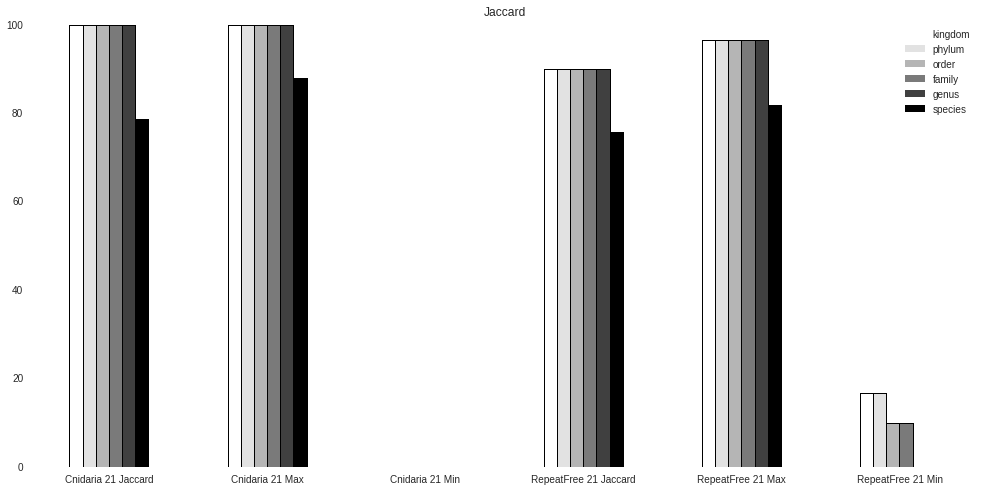

In [695]:
jacccard_bars = jaccard[  avail_cls ][ (jaccard.index == 'Cnidaria 21') |  (jaccard.index == 'RepeatFree 21') ].copy()
min_bars      = min_vals[ avail_cls ][ (jaccard.index == 'Cnidaria 21') |  (jaccard.index == 'RepeatFree 21') ].copy()
max_bars      = max_vals[ avail_cls ][ (jaccard.index == 'Cnidaria 21') |  (jaccard.index == 'RepeatFree 21') ].copy()

jacccard_bars.index = [ x + ' Jaccard' for x in min_bars.index ]
min_bars.index      = [ x + ' Min'     for x in min_bars.index ]
max_bars.index      = [ x + ' Max'     for x in max_bars.index ]

jbd = pd.concat([jacccard_bars, min_bars, max_bars])
jbd = jbd.sort_index(ascending=True)

print jbd

ax = jbd\
    .plot(
        kind='bar',
        lw=0,
        colormap='Greys',
        title='Jaccard', 
        figsize=(17, 8), 
        rot=360, 
        ylim=(0.0,101.0),
        edgecolor='black',
        grid=True
    )

    #'summer',
    #'gist_stern', #'hot',#'gist_heat',#'coolwarm',
    #'cool',#'binary',#'Spectral',#'Reds',
    #'Purples',#'Greys',#'CMRmap',#'BuPu',
    #'BrBG',#'Blues',#'Accent',#'winter',
    #'gist_rainbow',#'Greens',#'cubehelix',#'jet', 

plt.setp(ax.patches, linewidth=1)
print

In [522]:
pd1 = pd_data.drop('statistics', 1)

plt.figure(figsize=(17, 8))

#test_name statistics
parallel_coordinates(pd1, 'test_name')

plt.show()
plt.close()

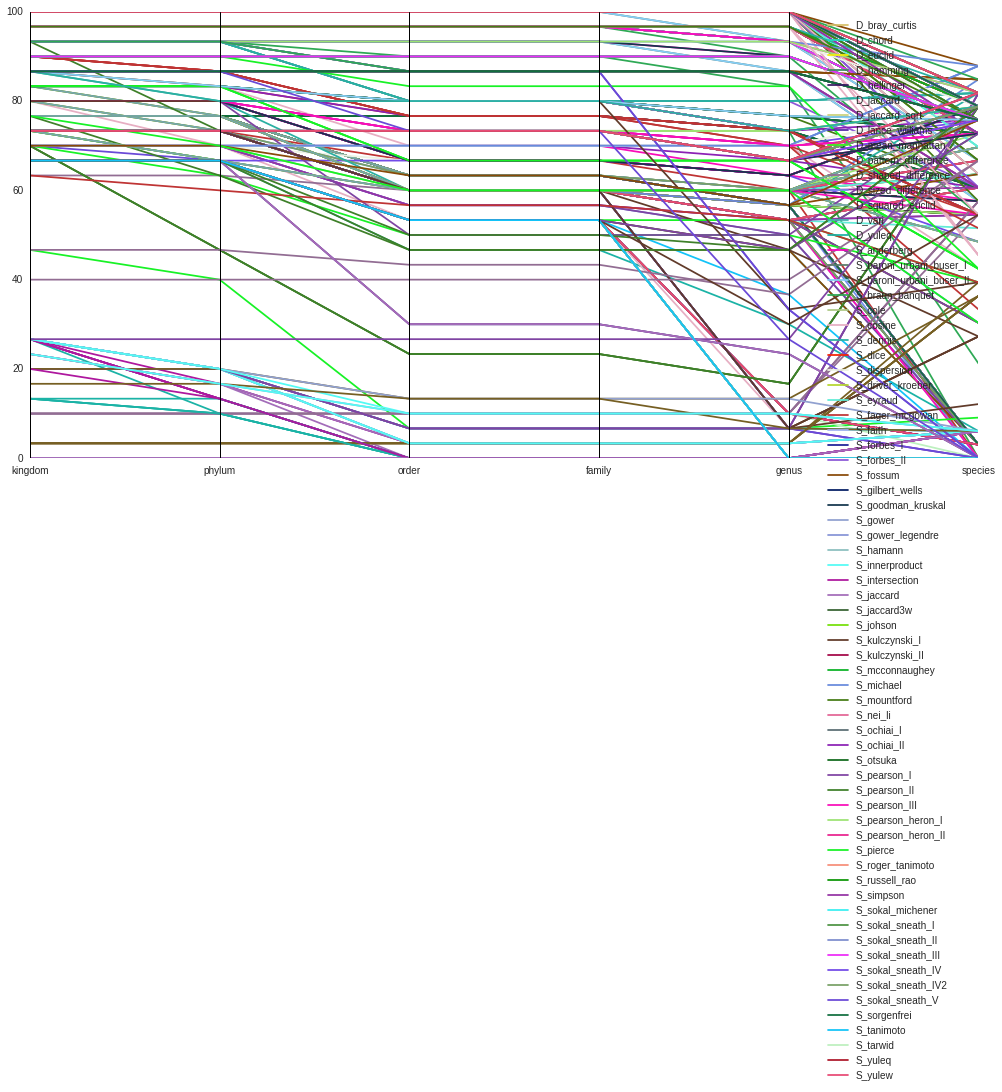

In [523]:
pd2 = pd_data.drop('test_name', 1)

plt.figure(figsize=(17, 8))

#test_name statistics
parallel_coordinates(pd2, 'statistics')

plt.show()
plt.close()

In [524]:
"""
147	Cnidaria 17	D_jaccard	96.666667	96.666667	96.666667	96.666667	93.333333	72.727273
163	Cnidaria 17	S_dennis	86.666667	80.000000	60.000000	60.000000	56.666667	81.818182
186	Cnidaria 17	S_michael	66.666667	66.666667	60.000000	60.000000	56.666667	84.848485


218	Cnidaria 21	D_jaccard	100.000000	100.000000	100.000000	100.000000	100.000000	78.787879
234	Cnidaria 21	S_dennis	93.333333	93.333333	80.000000	80.000000	80.000000	81.818182
243	Cnidaria 21	S_fossum	86.666667	86.666667	86.666667	86.666667	86.666667	84.848485
263	Cnidaria 21	S_pearson_I	20.000000	20.000000	6.666667	6.666667	6.666667	81.818182
"""

print

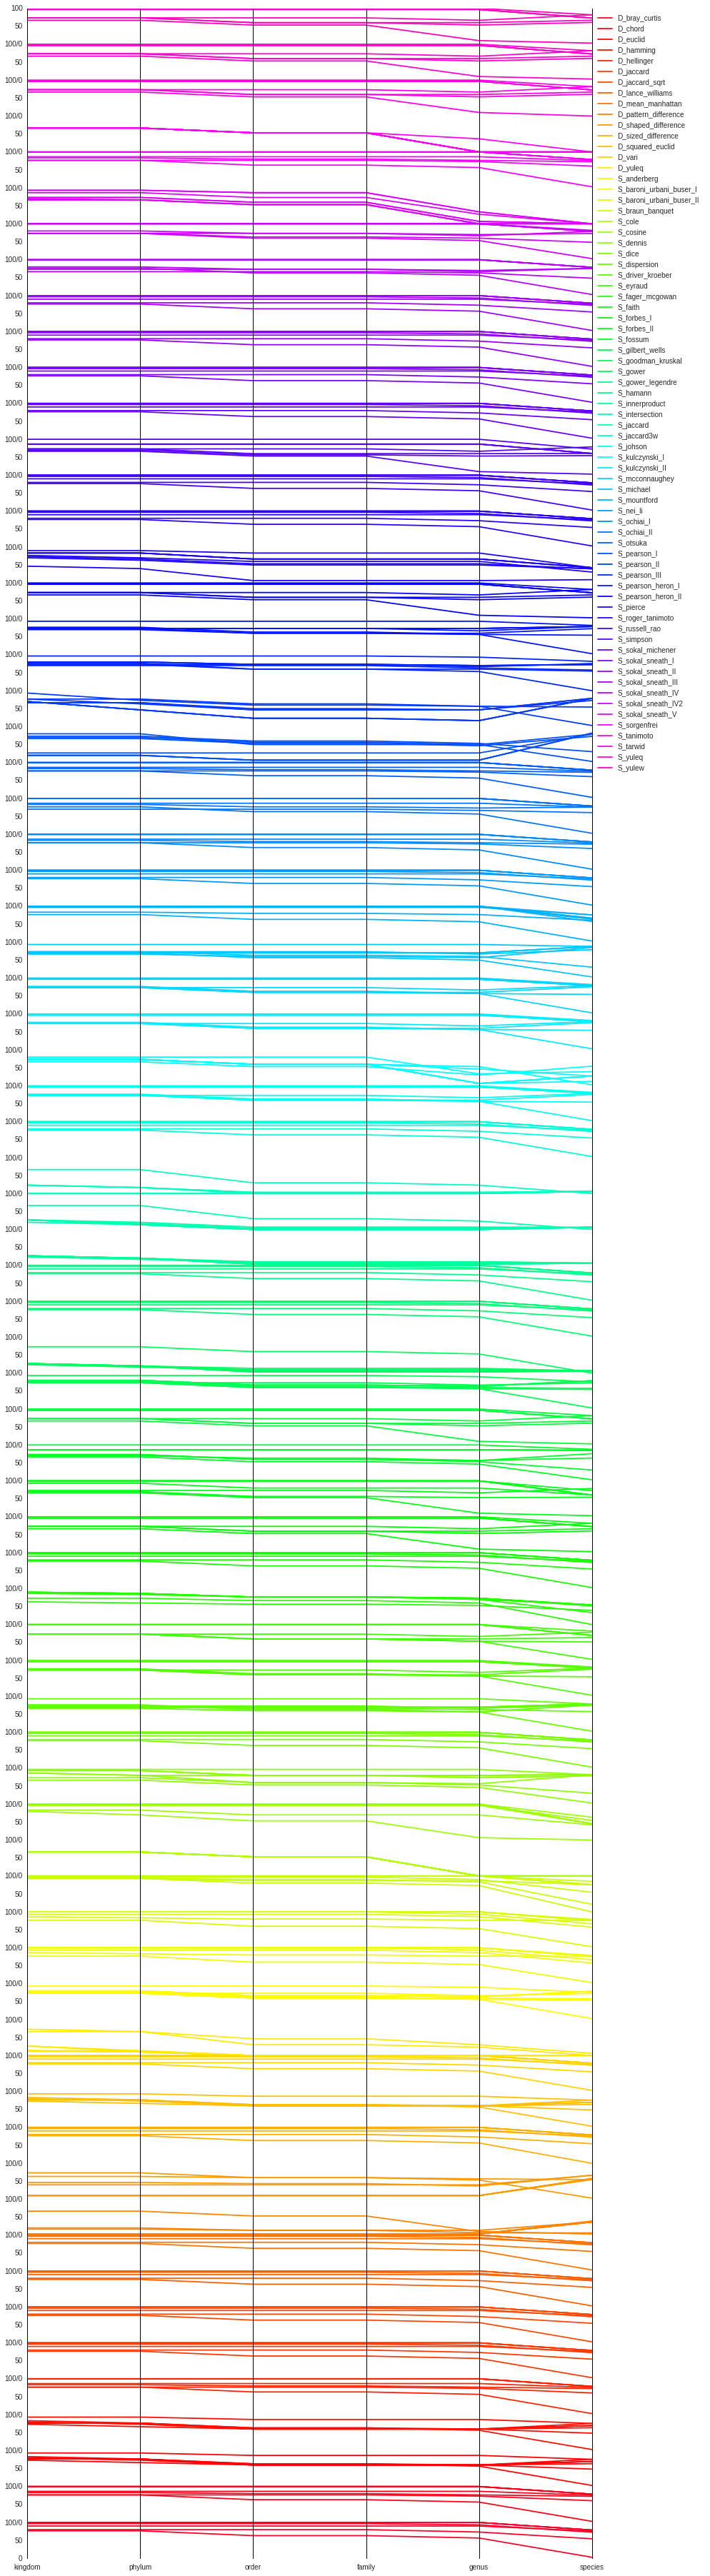

In [590]:
pd1 = pd_data.drop('test_name', 1)

for di, db in enumerate(stats):
    pd1.loc[ pd1['statistics'] == db, avail_cls ] += ((100.0*di)+1)

plt.figure(figsize=(17, 64))

pd1[""] = None

#test_name statistics
p = parallel_coordinates(pd1, 'statistics', colormap='gist_rainbow')
p.set_ylim(0, 100 * (len(stats)) + 1)

poses = range(0,len(stats)*100+50,50)
lbs   = ['0'] + (','.join(['50,100/0'] * (len(stats)-1))).split(',') + ['50','100']
plt.yticks(poses, lbs)

plt.show()
plt.close()

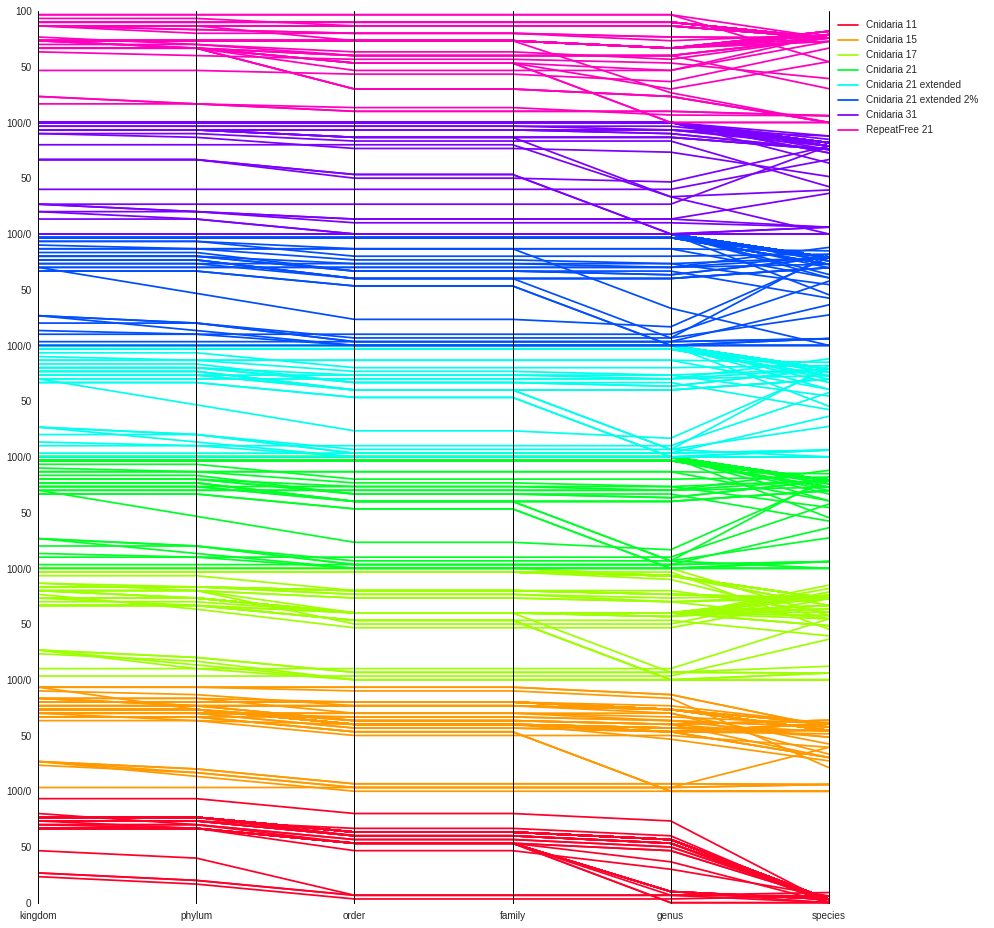

In [586]:
pd1 = pd_data.drop('statistics', 1)

for di, db in enumerate(dbs):
    pd1.loc[ pd1['test_name'] == db, avail_cls ] += ((100.0*di)+1)

plt.figure(figsize=(17, 16))

pd1[""] = None

#test_name statistics
p = parallel_coordinates(pd1, 'test_name', colormap='gist_rainbow')
p.set_ylim(0, 100 * (len(dbs)) + 1)

poses = range(0,len(dbs)*100+50,50)
lbs   = ['0'] + (','.join(['50,100/0'] * (len(dbs)-1))).split(',') + ['50','100']
plt.yticks(poses, lbs)

plt.show()
plt.close()